In [1]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import q_drydown, exponential_drydown, loss_model
import matplotlib.gridspec as gridspec

In [2]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2024-05-09"  # f"raraki_2024-04-26"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
z_mm = 50  # Soil thickness

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
}

In [3]:
# DATA IMPORT

# Data dir
user_name = getpass.getuser()
data_dir = rf"/home/{user_name}/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"
coord_info_file = "coord_info.csv"

# Read the output
output_dir = rf"/home/{user_name}/waves/projects/smap-drydown/output"
results_file = rf"all_results.csv"
_df = pd.read_csv(os.path.join(output_dir, dir_name, results_file))
print("Loaded results file")

# Read coordinate information
coord_info = pd.read_csv(os.path.join(data_dir, datarod_dir, coord_info_file))
df = _df.merge(coord_info, on=["EASE_row_index", "EASE_column_index"], how="left")
print("Loaded coordinate information")

# Ancillary data
df_anc = pd.read_csv(os.path.join(data_dir, datarod_dir, anc_file)).drop(
    ["spatial_ref", "latitude", "longitude"], axis=1
)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
print("Loaded ancillary information (sand fraction and land-cover)")

# Aridity indices
df_ai = pd.read_csv(os.path.join(data_dir, datarod_dir, ai_file)).drop(
    ["latitude", "longitude"], axis=1
)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
print("Loaded ancillary information (aridity index)")

IGBPclass = pd.read_csv(os.path.join(data_dir, anc_dir, IGBPclass_file))
IGBPclass.rename({"name": "landcover_name"}, inplace=True)

df = df.merge(df_anc, on=["EASE_row_index", "EASE_column_index"], how="left")
df = df.merge(df_ai, on=["EASE_row_index", "EASE_column_index"], how="left")
df = pd.merge(df, IGBPclass, left_on="IGBP_landcover", right_on="class", how="left")
print("Loaded ancillary information (land-cover)")

print(f"Total number of drydown event: {len(df)}")

Loaded results file
Loaded coordinate information
Loaded ancillary information (sand fraction and land-cover)
Loaded ancillary information (aridity index)
Loaded ancillary information (land-cover)
Total number of drydown event: 71828


In [4]:
fig_dir = os.path.join(output_dir, dir_name, "figs", "events")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Created dir: {fig_dir}")
else:
    print(f"Already exists: {fig_dir}")

Created dir: /home/raraki/waves/projects/smap-drydown/output/raraki_2024-05-09/figs/events


In [5]:
###################################
# Get some stats

# Difference between R2 values of two models
df = df.assign(diff_R2=df["q_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from q model
df["q_ETmax"] = df["q_k"] * (df["max_sm"] - df["min_sm"]) * z_mm
df["q_k_denormalized"] = df["q_k"] * (df["max_sm"] - df["min_sm"])


def filter_by_data_availability(df):
    # Define a helper function to convert string to list
    def str_to_list(s):
        return list(map(int, s.strip("[]").split()))

    # Convert the 'time' column from string of lists to actual lists
    df["time_list"] = df["time"].apply(str_to_list)

    # Filter condition 1: Check if first three items are [0, 1, 2]
    condition = df["time_list"].apply(lambda x: x[:3] == [0, 1, 2])

    # condition = df['time_list'].apply(
    #     lambda x: len(set(x[:4]).intersection({0, 1, 2, 3})) >= 3
    # )

    # Apply the first filter
    filtered_df = df[condition]

    return filtered_df


print(len(df))
df = filter_by_data_availability(df)
print(len(df))


# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)


def calculate_n_days(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    n_days = len(sm)
    return n_days


# Applying the function to each row and creating a new column 'sm_range'
df["n_days"] = df.apply(calculate_n_days, axis=1)

df["event_length"] = (
    pd.to_datetime(df["event_end"]) - pd.to_datetime(df["event_start"])
).dt.days

KeyError: 'q_k'

In [6]:
###################################
# Get some stats

# Difference between R2 values of two models
df = df.assign(diff_R2=df["q_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from q model
# df["q_ETmax"] = df["q_k"] * (df["max_sm"] - df["min_sm"]) * z_mm
# df["q_k_denormalized"] = df["q_k"] * (df["max_sm"] - df["min_sm"])


def filter_by_data_availability(df):
    # Define a helper function to convert string to list
    def str_to_list(s):
        return list(map(int, s.strip("[]").split()))

    # Convert the 'time' column from string of lists to actual lists
    df["time_list"] = df["time"].apply(str_to_list)

    # Filter condition 1: Check if first three items are [0, 1, 2]
    condition = df["time_list"].apply(lambda x: x[:3] == [0, 1, 2])

    # condition = df['time_list'].apply(
    #     lambda x: len(set(x[:4]).intersection({0, 1, 2, 3})) >= 3
    # )

    # Apply the first filter
    filtered_df = df[condition]

    return filtered_df


print(len(df))
df = filter_by_data_availability(df)
print(len(df))


# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)


def calculate_n_days(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    n_days = len(sm)
    return n_days


# Applying the function to each row and creating a new column 'sm_range'
df["n_days"] = df.apply(calculate_n_days, axis=1)

df["event_length"] = (
    pd.to_datetime(df["event_end"]) - pd.to_datetime(df["event_start"])
).dt.days

71828
31374


In [7]:
###################################
# Get some stats

# Difference between R2 values of two models
df = df.assign(diff_R2=df["q_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from q model
# df["q_ETmax"] = df["q_k"] * (df["max_sm"] - df["min_sm"]) * z_mm
# df["q_k_denormalized"] = df["q_k"] * (df["max_sm"] - df["min_sm"])


# def filter_by_data_availability(df):
#     # Define a helper function to convert string to list
#     def str_to_list(s):
#         return list(map(int, s.strip("[]").split()))

#     # Convert the 'time' column from string of lists to actual lists
#     df["time_list"] = df["time"].apply(str_to_list)

#     # Filter condition 1: Check if first three items are [0, 1, 2]
#     condition = df["time_list"].apply(lambda x: x[:3] == [0, 1, 2])

#     # condition = df['time_list'].apply(
#     #     lambda x: len(set(x[:4]).intersection({0, 1, 2, 3})) >= 3
#     # )

#     # Apply the first filter
#     filtered_df = df[condition]

#     return filtered_df


# print(len(df))
# df = filter_by_data_availability(df)
# print(len(df))


# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)


def calculate_n_days(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    n_days = len(sm)
    return n_days


# Applying the function to each row and creating a new column 'sm_range'
df["n_days"] = df.apply(calculate_n_days, axis=1)

df["event_length"] = (
    pd.to_datetime(df["event_end"]) - pd.to_datetime(df["event_start"])
).dt.days

In [8]:
# DATA IMPORT

# Data dir
user_name = getpass.getuser()
data_dir = rf"/home/{user_name}/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"
coord_info_file = "coord_info.csv"

# Read the output
output_dir = rf"/home/{user_name}/waves/projects/smap-drydown/output"
results_file = rf"all_results.csv"
_df = pd.read_csv(os.path.join(output_dir, dir_name, results_file))
print("Loaded results file")

# Read coordinate information
coord_info = pd.read_csv(os.path.join(data_dir, datarod_dir, coord_info_file))
df = _df.merge(coord_info, on=["EASE_row_index", "EASE_column_index"], how="left")
print("Loaded coordinate information")

# Ancillary data
df_anc = pd.read_csv(os.path.join(data_dir, datarod_dir, anc_file)).drop(
    ["spatial_ref", "latitude", "longitude"], axis=1
)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
print("Loaded ancillary information (sand fraction and land-cover)")

# Aridity indices
df_ai = pd.read_csv(os.path.join(data_dir, datarod_dir, ai_file)).drop(
    ["latitude", "longitude"], axis=1
)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
print("Loaded ancillary information (aridity index)")

IGBPclass = pd.read_csv(os.path.join(data_dir, anc_dir, IGBPclass_file))
IGBPclass.rename({"name": "landcover_name"}, inplace=True)

df = df.merge(df_anc, on=["EASE_row_index", "EASE_column_index"], how="left")
df = df.merge(df_ai, on=["EASE_row_index", "EASE_column_index"], how="left")
df = pd.merge(df, IGBPclass, left_on="IGBP_landcover", right_on="class", how="left")
print("Loaded ancillary information (land-cover)")

print(f"Total number of drydown event: {len(df)}")

Loaded results file
Loaded coordinate information
Loaded ancillary information (sand fraction and land-cover)
Loaded ancillary information (aridity index)
Loaded ancillary information (land-cover)
Total number of drydown event: 71828


In [9]:
fig_dir = os.path.join(output_dir, dir_name, "figs", "events")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Created dir: {fig_dir}")
else:
    print(f"Already exists: {fig_dir}")

Already exists: /home/raraki/waves/projects/smap-drydown/output/raraki_2024-05-09/figs/events


In [10]:
###################################
# Get some stats

# Difference between R2 values of two models
df = df.assign(diff_R2=df["q_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from q model
# df["q_ETmax"] = df["q_k"] * (df["max_sm"] - df["min_sm"]) * z_mm
# df["q_k_denormalized"] = df["q_k"] * (df["max_sm"] - df["min_sm"])


# def filter_by_data_availability(df):
#     # Define a helper function to convert string to list
#     def str_to_list(s):
#         return list(map(int, s.strip("[]").split()))

#     # Convert the 'time' column from string of lists to actual lists
#     df["time_list"] = df["time"].apply(str_to_list)

#     # Filter condition 1: Check if first three items are [0, 1, 2]
#     condition = df["time_list"].apply(lambda x: x[:3] == [0, 1, 2])

#     # condition = df['time_list'].apply(
#     #     lambda x: len(set(x[:4]).intersection({0, 1, 2, 3})) >= 3
#     # )

#     # Apply the first filter
#     filtered_df = df[condition]

#     return filtered_df


# print(len(df))
# df = filter_by_data_availability(df)
# print(len(df))


# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)


def calculate_n_days(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    n_days = len(sm)
    return n_days


# Applying the function to each row and creating a new column 'sm_range'
df["n_days"] = df.apply(calculate_n_days, axis=1)

df["event_length"] = (
    pd.to_datetime(df["event_end"]) - pd.to_datetime(df["event_start"])
).dt.days

In [11]:
############################################################
# Get timeseries of SM data
############################################################


def get_filename(varname, EASE_row_index, EASE_column_index):
    """Get the filename of the datarod"""
    filename = f"{varname}_{EASE_row_index:03d}_{EASE_column_index:03d}.csv"
    return filename


def set_time_index(df, index_name="time"):
    """Set the datetime index to the pandas dataframe"""
    df[index_name] = pd.to_datetime(df[index_name])
    return df.set_index("time")


def get_dataframe(varname, event):
    """Get the pandas dataframe for a datarod of interest

    Args:
        varname (string): name of the variable: "SPL3SMP", "PET", "SPL4SMGP"

    Returns:
        dataframe: Return dataframe with datetime index, cropped for the timeperiod for a variable
    """

    fn = get_filename(
        varname,
        EASE_row_index=event.EASE_row_index,
        EASE_column_index=event.EASE_column_index,
    )
    _df = pd.read_csv(os.path.join(data_dir, datarod_dir, varname, fn))

    # Set time index and crop
    df = set_time_index(_df, index_name="time")
    return df


def get_soil_moisture(varname="SPL3SMP", event=None):
    """Get a datarod of soil moisture data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Use retrieval flag to quality control the data
    condition_bad_data_am = (
        _df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 8.0)
    condition_bad_data_pm = (
        _df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 8.0)
    _df.loc[condition_bad_data_am, "Soil_Moisture_Retrieval_Data_AM_soil_moisture"] = (
        np.nan
    )
    _df.loc[
        condition_bad_data_pm, "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm"
    ] = np.nan

    # If there is two different versions of 2015-03-31 data --- remove this
    df = _df.loc[~_df.index.duplicated(keep="first")]

    # Resample to regular time interval
    df = df.resample("D").asfreq()

    # Merge the AM and PM soil moisture data into one daily timeseries of data
    df["soil_moisture_daily"] = df[
        [
            "Soil_Moisture_Retrieval_Data_AM_soil_moisture",
            "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm",
        ]
    ].mean(axis=1, skipna=True)

    return df["soil_moisture_daily"]


def get_precipitation(varname="SPL4SMGP", event=None):
    """Get a datarod of precipitation data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Drop unnccesary dimension and change variable name
    _df = _df.drop(columns=["x", "y"]).rename(
        {"precipitation_total_surface_flux": "precip"}, axis="columns"
    )

    # Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
    _df.precip = _df.precip * 86400

    # Resample to regular time interval
    return _df.resample("D").asfreq()

In [12]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)
    k = event.q_k
    q = event.q_q

    min_sm = event.min_sm
    max_sm = event.max_sm
    norm_max = max_sm * 0.95
    norm_min = min_sm

    exp_delta_theta = event.exp_delta_theta
    theta_w = event.exp_theta_w
    tau = event.exp_tau
    z = 50

    theta_0 = event.q_theta_0
    theta_0_denorm = (event.q_theta_0) * (norm_max - norm_min)

    print(theta_0, theta_0_denorm)
    ETmax = k * (norm_max - norm_min) * z
    y_nonlinear = (q_drydown(t=t, k=k, q=q, theta_0=theta_0)) * (
        norm_max - norm_min
    ) + norm_min
    y_exp = exponential_drydown(t, exp_delta_theta, theta_w, tau)

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    nonlinear_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={q:.1f}, $ETmax$={ETmax:.1f}, $\theta_0$={theta_0_denorm:.2f})"
    linear_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $\tau$={tau:.2f}, $\Delta \theta$={exp_delta_theta:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(date_range[:-1], y_exp, label=linear_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_nonlinear, label=nonlinear_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=max_sm, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    ####################################################
    # Loss function
    ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    theta_plot = np.arange(norm_min, norm_max, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        theta_plot,
        loss_model(
            theta_plot,
            q,
            k * (norm_max - norm_min),
            theta_wp=norm_min,
            theta_star=norm_max,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            q,
            k * (norm_max - norm_min),
            theta_wp=norm_min,
            theta_star=norm_max,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        theta_plot,
        loss_model(
            theta_plot,
            1,
            k * (norm_max - norm_min),
            theta_wp=norm_min,
            theta_star=norm_max,
        ),
        color="darkblue",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            k * (norm_max - norm_min),
            theta_wp=norm_min,
            theta_star=norm_max,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [13]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([51651, 13220, 18099, 8571, 26400], dtype='int64')


In [14]:
################################################
event_id = 503295
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

KeyError: 503295

In [15]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([11545, 62924, 14509, 69766, 19965], dtype='int64')


In [16]:
################################################
event_id = 11545
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

AttributeError: 'Series' object has no attribute 'q_k'

In [17]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
)
from functions import loss_model
import matplotlib.gridspec as gridspec

ImportError: cannot import name 'loss_model' from 'functions_v2' (/home/raraki/smap-drydown/notebooks/functions_v2.py)

In [18]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
)
from functions import loss_model
import matplotlib.gridspec as gridspec

In [19]:
event = df.loc[event_id]

In [20]:
event.sm

'[0.25643054 0.20585708 0.18055645 0.1687015  0.1404582  0.14803785\n 0.11411752]'

In [21]:
event.columns

AttributeError: 'Series' object has no attribute 'columns'

In [22]:
event

Unnamed: 0                                                           26
EASE_row_index                                                       61
EASE_column_index                                                   209
event_start                                                  2020-07-30
event_end                                                    2020-08-06
time                                                    [0 2 3 4 5 6 7]
sm                    [0.25643054 0.20585708 0.18055645 0.1687015  0...
min_sm                                                         0.038743
max_sm                                                         0.413512
est_theta_fc                                                   0.292783
pet                                                            6.181788
tauexp_delta_theta                                             0.218112
tauexp_theta_w                                                 0.038743
tauexp_tau                                                     7

In [23]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t,
        q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        event.q_theta_0,
        event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(,
        t,
        exp_model(
        t,
        event.exp_ETmax,
        event.exp_theta_0,
        event.exp_theta_star,
        event.exp_theta_w,
        z=50.0
        ),
        event.q_theta_0,
        event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $theta^*$={event.q_theta_star:.2f}, $theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $theta^*$={event.exp_theta_star:.2f}, $theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={tauexp_tau:.2f}, $\Delta \theta$={tauexp_delta_theta:.2f}), $\tauexp_theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="-",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=max_sm, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

SyntaxError: invalid syntax (<ipython-input-23-87d4d454421f>, line 43)

In [24]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t,
        q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        event.q_theta_0,
        event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t,
        exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        event.q_theta_0,
        event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $theta^*$={event.q_theta_star:.2f}, $theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $theta^*$={event.exp_theta_star:.2f}, $theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={tauexp_tau:.2f}, $\Delta \theta$={tauexp_delta_theta:.2f}), $\tauexp_theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="-",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=max_sm, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [25]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([62475, 45296, 40547, 49726, 52621], dtype='int64')


In [26]:
################################################
event_id = 11545
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

TypeError: drydown_piecewise() missing 1 required positional argument: 'theta_star'

In [27]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $theta^*$={event.q_theta_star:.2f}, $theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $theta^*$={event.exp_theta_star:.2f}, $theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={tauexp_tau:.2f}, $\Delta \theta$={tauexp_delta_theta:.2f}), $\tauexp_theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="-",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=max_sm, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [28]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([43575, 50148, 44600, 9537, 15906], dtype='int64')


In [29]:
################################################
event_id = 11545
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

TypeError: drydown_piecewise() missing 1 required positional argument: 'ETmax'

In [30]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $theta^*$={event.q_theta_star:.2f}, $theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $theta^*$={event.exp_theta_star:.2f}, $theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={tauexp_tau:.2f}, $\Delta \theta$={tauexp_delta_theta:.2f}), $\tauexp_theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="-",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=max_sm, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [31]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([15881, 14420, 69526, 56032, 13525], dtype='int64')


In [32]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

NameError: name 'tauexp_tau' is not defined

In [33]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $theta^*$={event.q_theta_star:.2f}, $theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $theta^*$={event.exp_theta_star:.2f}, $theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={tauexp_delta_theta:.2f}), $\tauexp_theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="-",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=max_sm, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [34]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([31865, 44624, 3065, 53181, 47624], dtype='int64')


In [35]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

NameError: name 'tauexp_delta_theta' is not defined

In [36]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $theta^*$={event.q_theta_star:.2f}, $theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $theta^*$={event.exp_theta_star:.2f}, $theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\tauexp_theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="-",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=max_sm, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [37]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([23925, 19266, 49053, 38689, 42451], dtype='int64')


In [38]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

<ipython-input-36-10e3183f2831>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


NameError: name 'max_sm' is not defined

Error in callback <function _draw_all_if_interactive at 0x7fb92fb727a0> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
\tauexp_theta_w
^
ParseFatalException: Unknown symbol: \tauexp, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\tauexp_theta_w
^
ParseFatalException: Unknown symbol: \tauexp, found '\'  (at char 0), (line:1, col:1)

<Figure size 1000x350 with 2 Axes>

In [39]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $theta^*$={event.q_theta_star:.2f}, $theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $theta^*$={event.exp_theta_star:.2f}, $theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="-",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=max_sm, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [40]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([24982, 21005, 21197, 64206, 68088], dtype='int64')


<ipython-input-39-72702ce8c703>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


NameError: name 'max_sm' is not defined

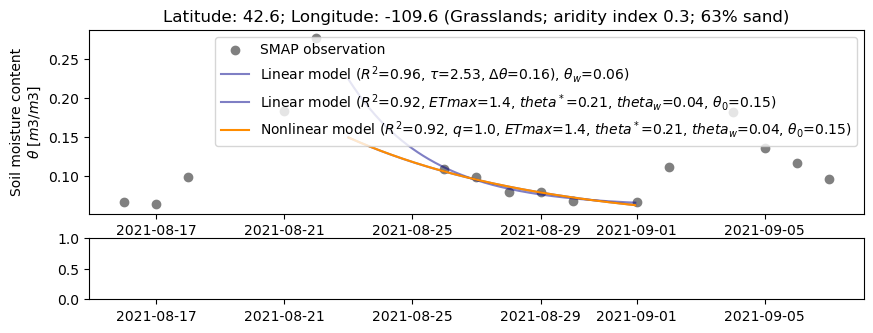

In [41]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [42]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $theta^*$={event.exp_theta_star:.2f}, $theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=max_sm, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [43]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([12507, 25760, 43493, 45892, 17165], dtype='int64')


<ipython-input-42-66ae3b77204f>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


NameError: name 'max_sm' is not defined

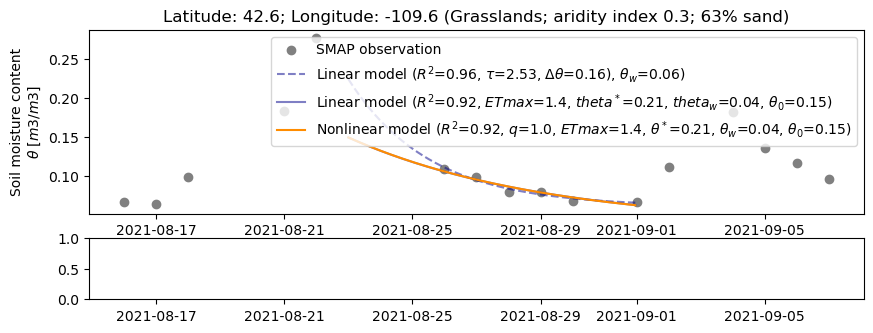

In [44]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [45]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(10, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=event.est_theta_fc, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [46]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([46709, 71327, 55669, 52158, 59213], dtype='int64')


<ipython-input-45-e5becc994f33>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           14
EASE_row_index                                                       65
EASE_column_index                                                   188
event_start                                                  2021-08-23
event_end                                                    2021-09-01
time                                                      [3 4 5 6 7 9]
sm                    [0.10951298 0.0992365  0.07923665 0.07894054 0...
min_sm                                                         0.036679
max_sm                                                         0.298676
est_theta_fc                                                   0.218816
pet                                                            4.739246
tauexp_delta_theta                                             0.163475
tauexp_theta_w                                                 0.060946
tauexp_tau                                                     2

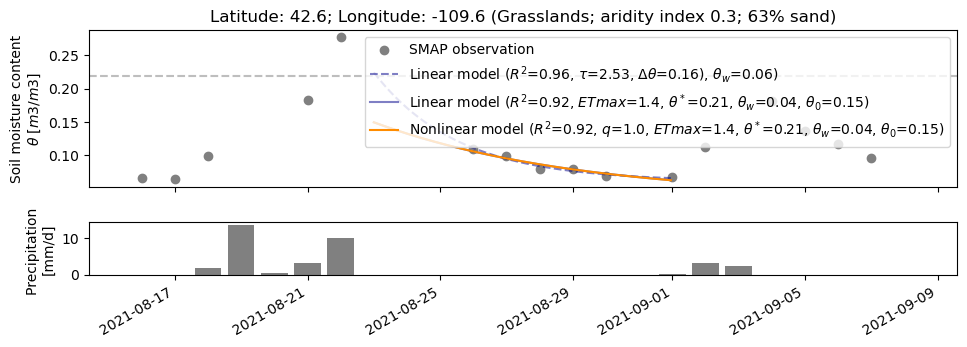

In [47]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [48]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=event.est_theta_fc, color="tab:grey", linestyle="--", alpha=0.5)
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [49]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([6758, 35621, 2531, 22622, 64713], dtype='int64')


<ipython-input-48-603039373e68>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           14
EASE_row_index                                                       65
EASE_column_index                                                   188
event_start                                                  2021-08-23
event_end                                                    2021-09-01
time                                                      [3 4 5 6 7 9]
sm                    [0.10951298 0.0992365  0.07923665 0.07894054 0...
min_sm                                                         0.036679
max_sm                                                         0.298676
est_theta_fc                                                   0.218816
pet                                                            4.739246
tauexp_delta_theta                                             0.163475
tauexp_theta_w                                                 0.060946
tauexp_tau                                                     2

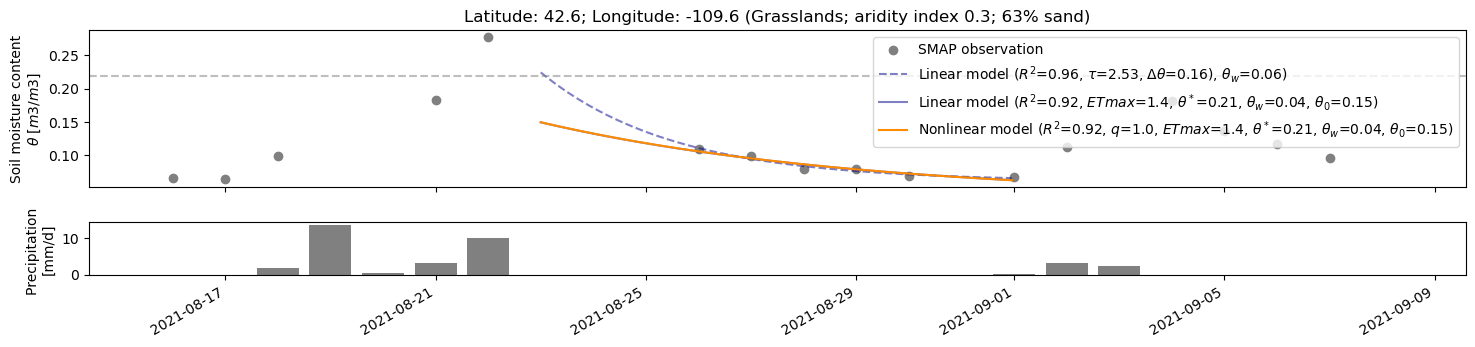

In [50]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [51]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=event.est_theta_fc, color="tab:grey", linestyle="--", alpha=0.5, label=rf"Estimated \theta_{fc}")
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [52]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([50123, 26851, 10973, 26347, 558], dtype='int64')


<ipython-input-51-493dd73819f1>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


NameError: name 'fc' is not defined

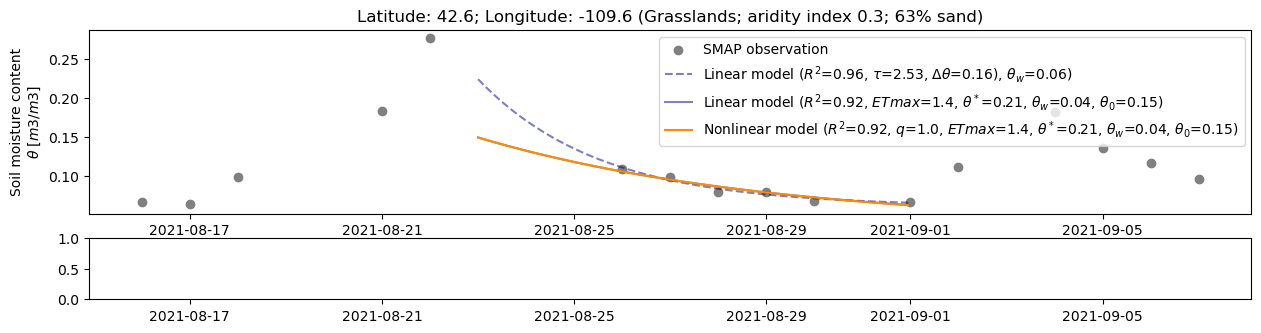

In [53]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [54]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    ax1.axhline(y=event.est_theta_fc, color="tab:grey", linestyle="--", alpha=0.5, label=r"Estimated \theta_{fc}")
    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [55]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([48986, 3363, 45927, 6245, 21737], dtype='int64')


<ipython-input-54-f531e8ea94dd>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           14
EASE_row_index                                                       65
EASE_column_index                                                   188
event_start                                                  2021-08-23
event_end                                                    2021-09-01
time                                                      [3 4 5 6 7 9]
sm                    [0.10951298 0.0992365  0.07923665 0.07894054 0...
min_sm                                                         0.036679
max_sm                                                         0.298676
est_theta_fc                                                   0.218816
pet                                                            4.739246
tauexp_delta_theta                                             0.163475
tauexp_theta_w                                                 0.060946
tauexp_tau                                                     2

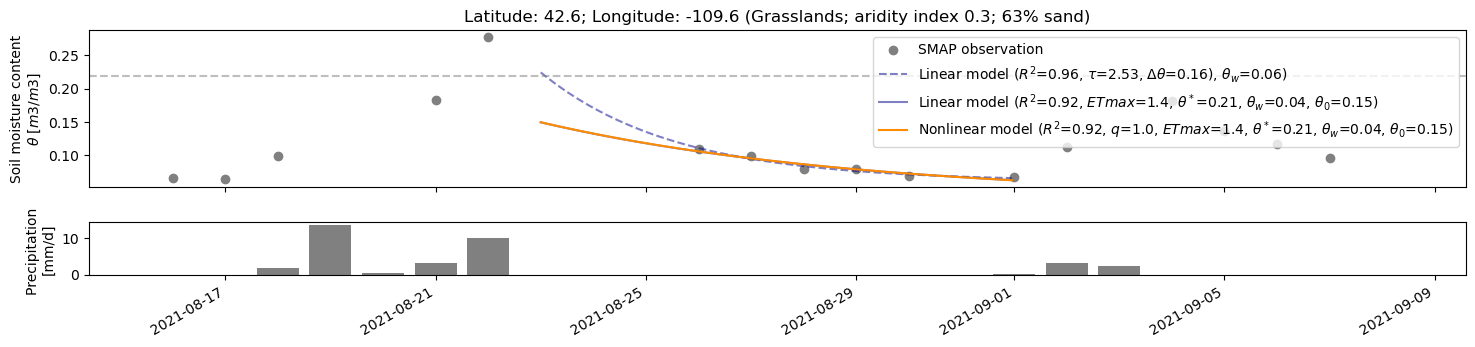

In [56]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [57]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(y=event.est_theta_fc, color="tab:grey", linestyle="--", alpha=0.5, label=r"Estimated \theta_{fc}")
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

# Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [58]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([2851, 8638, 43248, 64300, 1514], dtype='int64')


<ipython-input-57-ce3b1813e5a1>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           14
EASE_row_index                                                       65
EASE_column_index                                                   188
event_start                                                  2021-08-23
event_end                                                    2021-09-01
time                                                      [3 4 5 6 7 9]
sm                    [0.10951298 0.0992365  0.07923665 0.07894054 0...
min_sm                                                         0.036679
max_sm                                                         0.298676
est_theta_fc                                                   0.218816
pet                                                            4.739246
tauexp_delta_theta                                             0.163475
tauexp_theta_w                                                 0.060946
tauexp_tau                                                     2

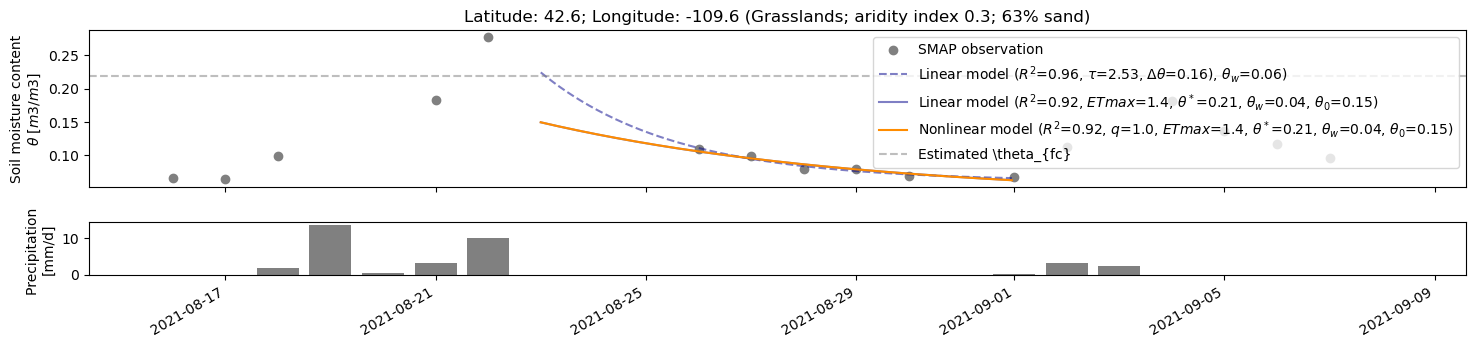

In [59]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [60]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(7, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [61]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([33058, 3005, 63355, 3663, 18028], dtype='int64')


<ipython-input-60-53d1bb883764>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           14
EASE_row_index                                                       65
EASE_column_index                                                   188
event_start                                                  2021-08-23
event_end                                                    2021-09-01
time                                                      [3 4 5 6 7 9]
sm                    [0.10951298 0.0992365  0.07923665 0.07894054 0...
min_sm                                                         0.036679
max_sm                                                         0.298676
est_theta_fc                                                   0.218816
pet                                                            4.739246
tauexp_delta_theta                                             0.163475
tauexp_theta_w                                                 0.060946
tauexp_tau                                                     2

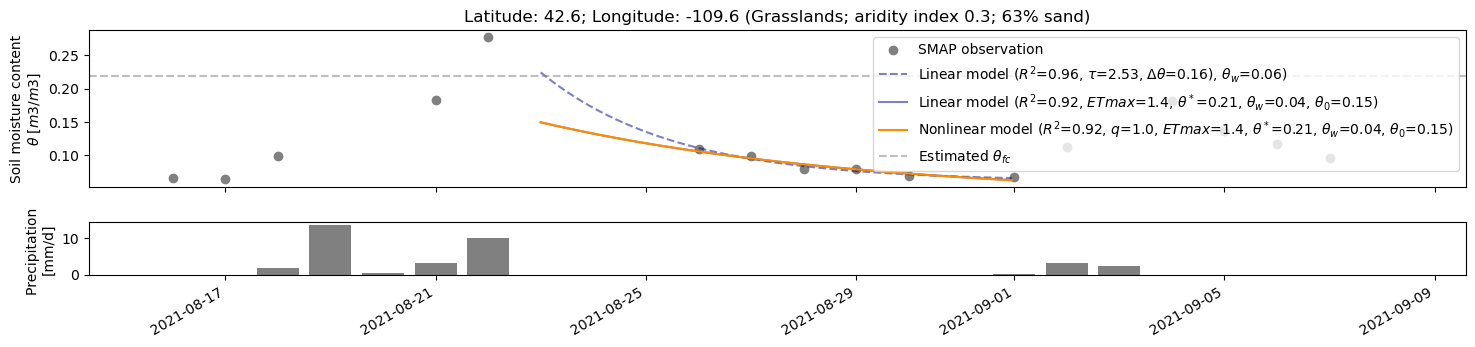

In [62]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [63]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    # fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    # theta_obs = df_ts[
    #     pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    # ].values

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkorange",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         q,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # # Plot observed & fitted soil moisture
    # ax3.plot(
    #     theta_plot,
    #     loss_model(
    #         theta_plot,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="darkblue",
    # )

    # # Plot observed & fitted soil moisture
    # ax3.scatter(
    #     theta_obs,
    #     loss_model(
    #         theta_obs,
    #         1,
    #         k * (norm_max - norm_min),
    #         theta_wp=norm_min,
    #         theta_star=norm_max,
    #     ),
    #     color="grey",
    #     alpha=0.5,
    # )

    # ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    # ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    # ax3.invert_yaxis()

In [64]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([21391, 1638, 52735, 65567, 38915], dtype='int64')


<ipython-input-63-308944f1d98d>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           14
EASE_row_index                                                       65
EASE_column_index                                                   188
event_start                                                  2021-08-23
event_end                                                    2021-09-01
time                                                      [3 4 5 6 7 9]
sm                    [0.10951298 0.0992365  0.07923665 0.07894054 0...
min_sm                                                         0.036679
max_sm                                                         0.298676
est_theta_fc                                                   0.218816
pet                                                            4.739246
tauexp_delta_theta                                             0.163475
tauexp_theta_w                                                 0.060946
tauexp_tau                                                     2

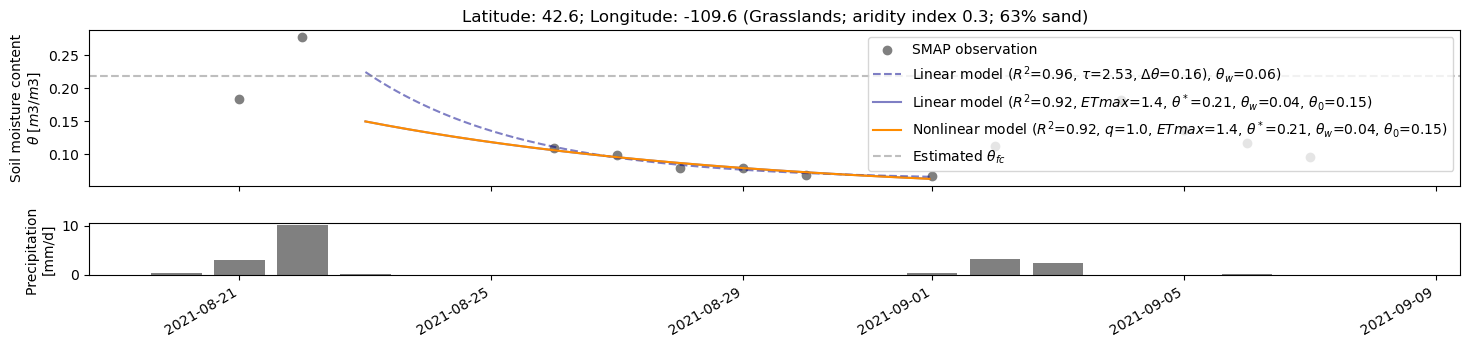

In [65]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [66]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
)
import matplotlib.gridspec as gridspec

ImportError: cannot import name 'loss_model' from 'functions_v2' (/home/raraki/smap-drydown/notebooks/functions_v2.py)

In [67]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        theta_plot,
        loss_model(
            np.arange(event.q_theta_w, event.q_theta_star, 0.01),
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        theta_plot,
        loss_model(
            np.arange(event.exp_theta_w, event..exp_theta_star, 0.01),
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

SyntaxError: invalid syntax (<ipython-input-67-d0415d2fc2f7>, line 193)

In [ ]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

: 

<ipython-input-63-308944f1d98d>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           14
EASE_row_index                                                       65
EASE_column_index                                                   188
event_start                                                  2021-08-23
event_end                                                    2021-09-01
time                                                      [3 4 5 6 7 9]
sm                    [0.10951298 0.0992365  0.07923665 0.07894054 0...
min_sm                                                         0.036679
max_sm                                                         0.298676
est_theta_fc                                                   0.218816
pet                                                            4.739246
tauexp_delta_theta                                             0.163475
tauexp_theta_w                                                 0.060946
tauexp_tau                                                     2

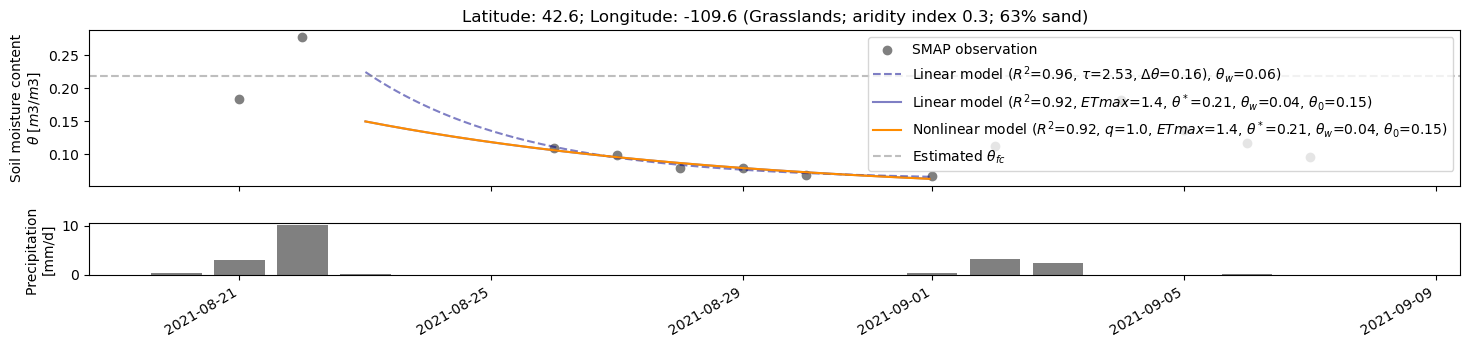

In [68]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [69]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    # theta_plot = np.arange(norm_min, norm_max, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        theta_plot,
        loss_model(
            np.arange(event.q_theta_w, event.q_theta_star, 0.01),
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        theta_plot,
        loss_model(
            np.arange(event.exp_theta_w, event.exp_theta_star, 0.01),
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [70]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([57901, 24533, 6159, 38700, 57545], dtype='int64')


<ipython-input-69-485c48c4b96f>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


NameError: name 'theta_plot' is not defined

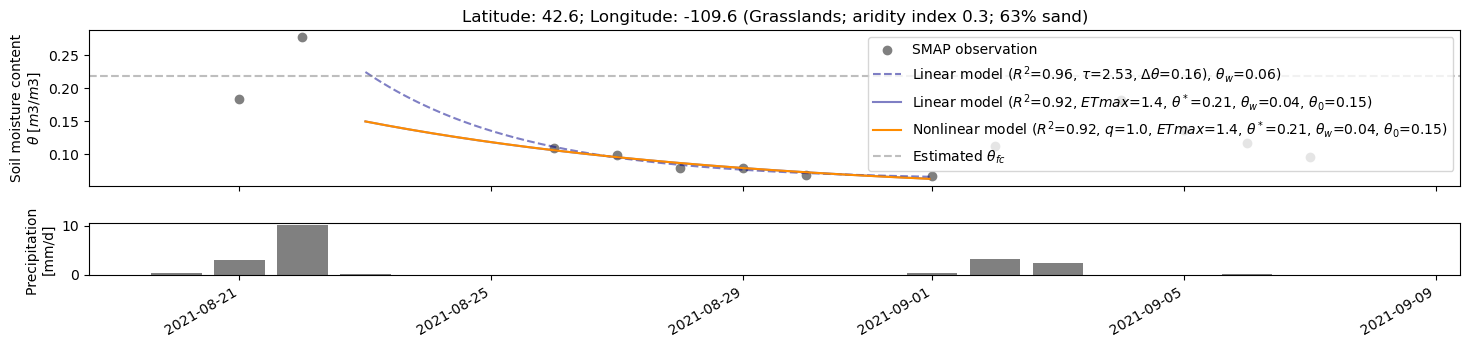

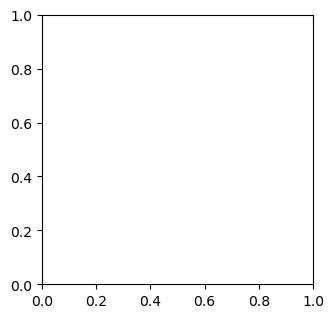

In [71]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [72]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [73]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([71420, 57067, 26461, 70903, 23495], dtype='int64')


<ipython-input-72-421e728ff567>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           14
EASE_row_index                                                       65
EASE_column_index                                                   188
event_start                                                  2021-08-23
event_end                                                    2021-09-01
time                                                      [3 4 5 6 7 9]
sm                    [0.10951298 0.0992365  0.07923665 0.07894054 0...
min_sm                                                         0.036679
max_sm                                                         0.298676
est_theta_fc                                                   0.218816
pet                                                            4.739246
tauexp_delta_theta                                             0.163475
tauexp_theta_w                                                 0.060946
tauexp_tau                                                     2

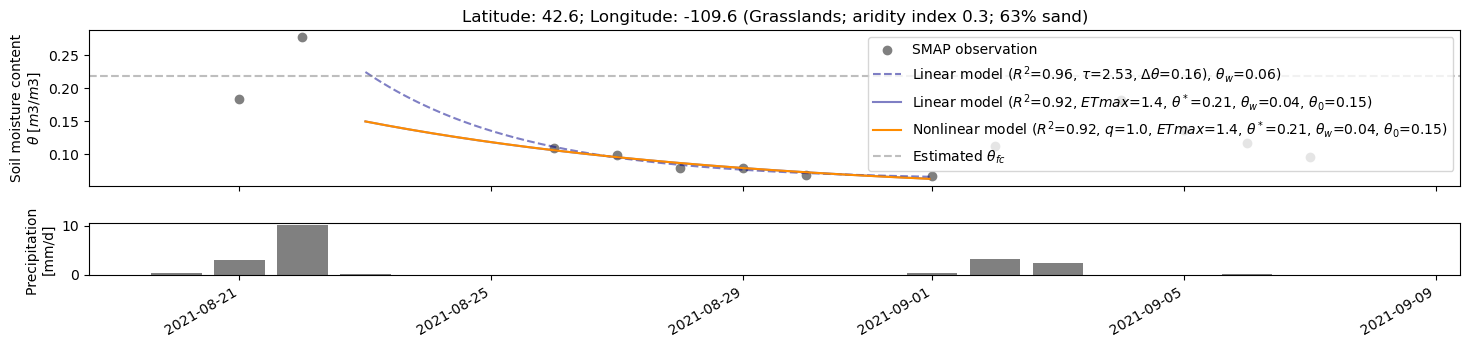

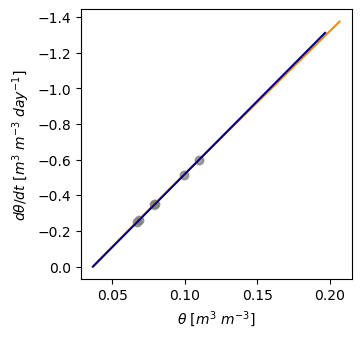

In [74]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [75]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [76]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["sm_range"] > 0.1)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12892)
Try: Index([9192, 5668, 60874, 15539, 56064], dtype='int64')


<ipython-input-75-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           14
EASE_row_index                                                       65
EASE_column_index                                                   188
event_start                                                  2021-08-23
event_end                                                    2021-09-01
time                                                      [3 4 5 6 7 9]
sm                    [0.10951298 0.0992365  0.07923665 0.07894054 0...
min_sm                                                         0.036679
max_sm                                                         0.298676
est_theta_fc                                                   0.218816
pet                                                            4.739246
tauexp_delta_theta                                             0.163475
tauexp_theta_w                                                 0.060946
tauexp_tau                                                     2

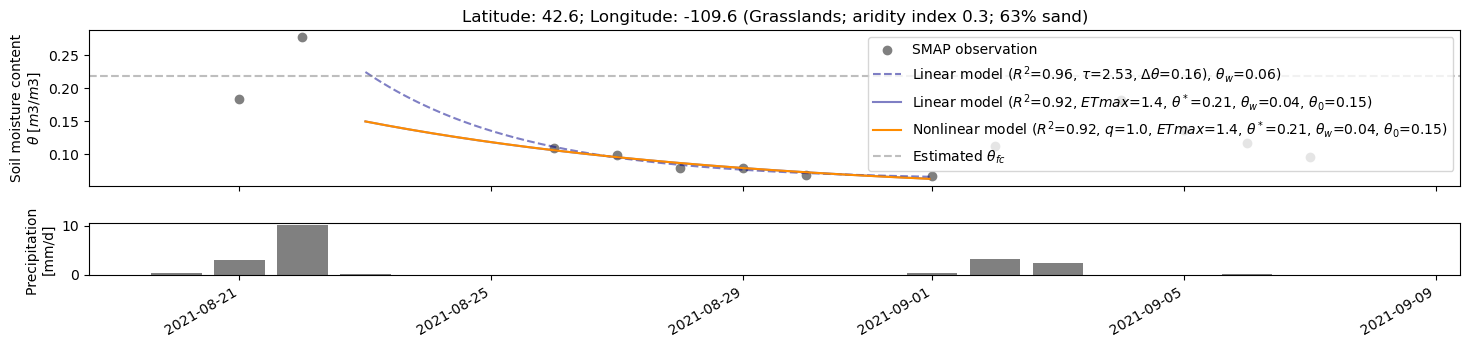

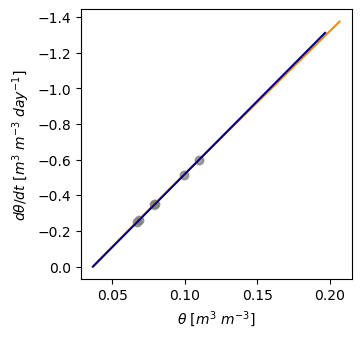

In [77]:
################################################
event_id = 15881
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [78]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] < 1)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([    5,    13,    15,    27,    28,    31,    32,    37,    47,    48,
       ...
       71791, 71793, 71796, 71799, 71804, 71807, 71814, 71817, 71822, 71823],
      dtype='int64', length=12902)
Try: Index([58731, 65830, 24570, 50134, 5676], dtype='int64')


<ipython-input-75-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           17
EASE_row_index                                                      101
EASE_column_index                                                   189
event_start                                                  2018-02-20
event_end                                                    2018-02-25
time                                                        [0 1 2 3 5]
sm                    [0.25992927 0.25389367 0.21175049 0.18645293 0...
min_sm                                                         0.068794
max_sm                                                         0.420815
est_theta_fc                                                   0.285872
pet                                                            3.508433
tauexp_delta_theta                                             0.204827
tauexp_theta_w                                                 0.068794
tauexp_tau                                                      

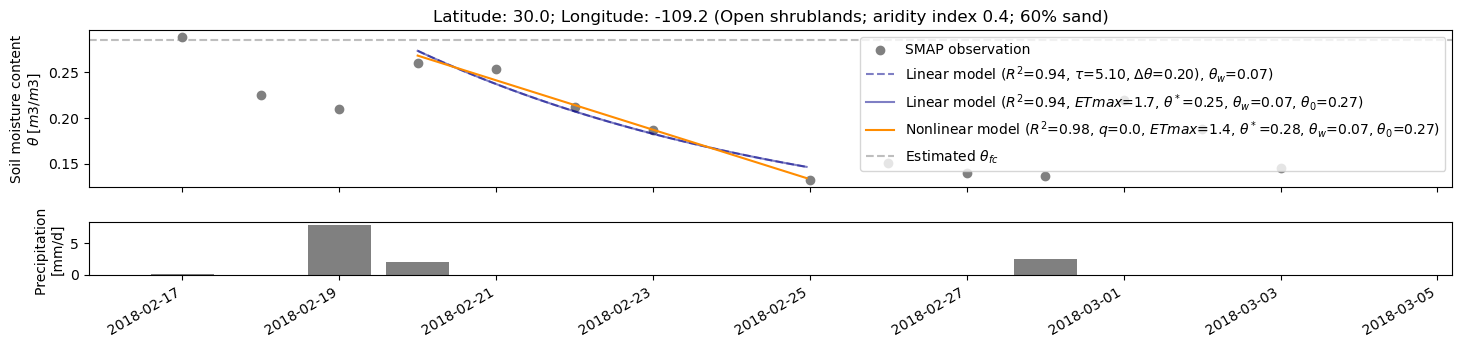

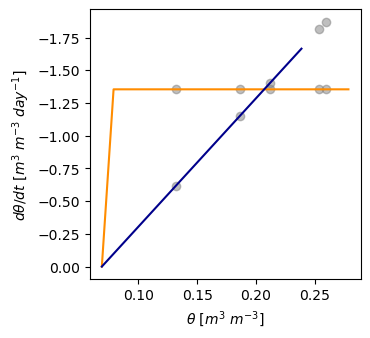

In [79]:
################################################
event_id = 58731
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

<ipython-input-75-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           24
EASE_row_index                                                       62
EASE_column_index                                                   206
event_start                                                  2021-08-20
event_end                                                    2021-08-25
time                                                        [0 1 2 3 4]
sm                    [0.17227344 0.1701827  0.14618202 0.11537777 0...
min_sm                                                         0.042017
max_sm                                                         0.444923
est_theta_fc                                                   0.253253
pet                                                             7.04432
tauexp_delta_theta                                             0.140319
tauexp_theta_w                                                 0.042017
tauexp_tau                                                     5

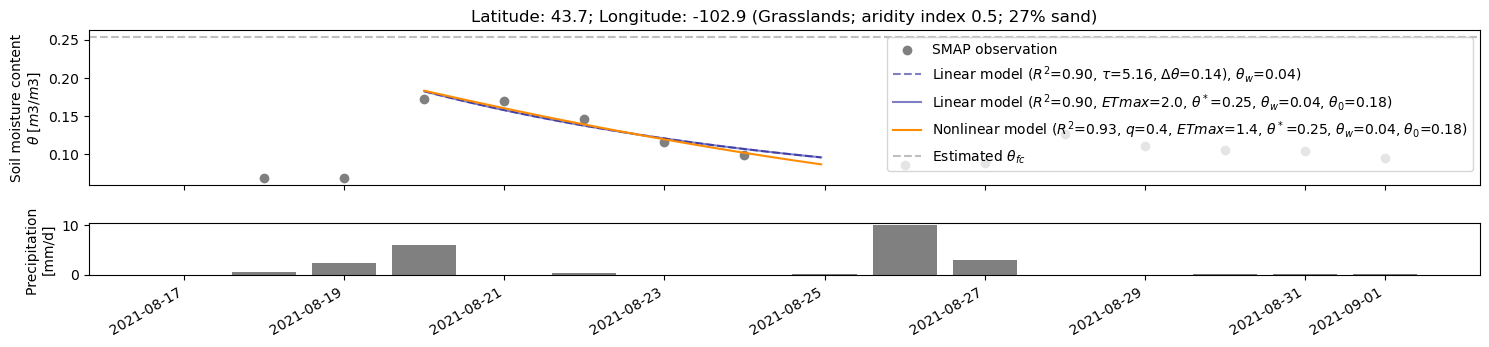

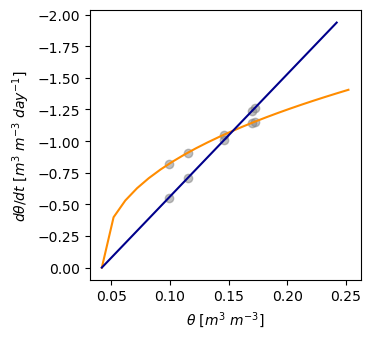

In [80]:
################################################
event_id = 12589
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [81]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([  652,   766,   768,   811,   903,  1607,  1770,  1799,  1802,  1867,
       ...
       63886, 64901, 65884, 66507, 66582, 66664, 68577, 69604, 70993, 71100],
      dtype='int64', length=186)
Try: Index([7582, 14919, 49391, 2292, 57181], dtype='int64')


<ipython-input-75-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                           16
EASE_row_index                                                       57
EASE_column_index                                                   192
event_start                                                  2022-11-02
event_end                                                    2022-11-12
time                                                        [0 1 3 5 6]
sm                    [0.17601583 0.14799456 0.14445476 0.1353024  0...
min_sm                                                         0.034219
max_sm                                                         0.321795
est_theta_fc                                                   0.240094
pet                                                            3.272145
tauexp_delta_theta                                             0.039649
tauexp_theta_w                                                 0.135302
tauexp_tau                                                     1

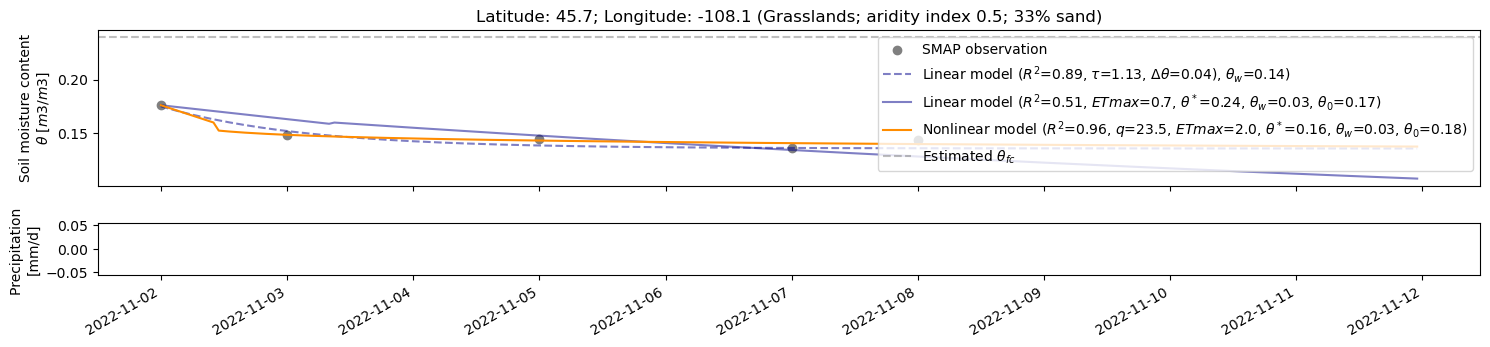

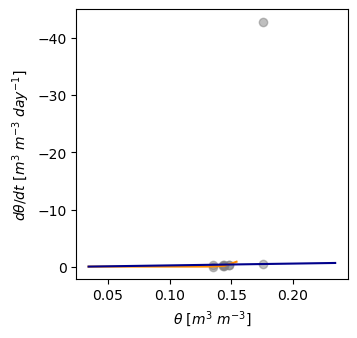

In [82]:
################################################
event_id = 7582
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

<ipython-input-75-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            6
EASE_row_index                                                       76
EASE_column_index                                                   248
event_start                                                  2022-07-26
event_end                                                    2022-08-07
time                                                        [0 3 5 6 8]
sm                    [0.30590534 0.2696825  0.25312774 0.26704953 0...
min_sm                                                         0.104602
max_sm                                                         0.418532
est_theta_fc                                                   0.307898
pet                                                            5.324892
tauexp_delta_theta                                             0.052237
tauexp_theta_w                                                 0.253128
tauexp_tau                                                     2

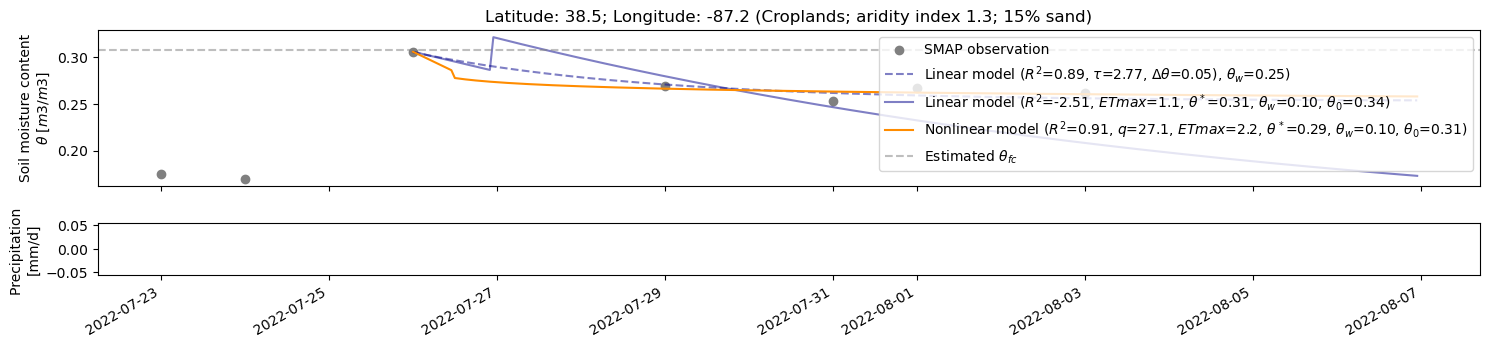

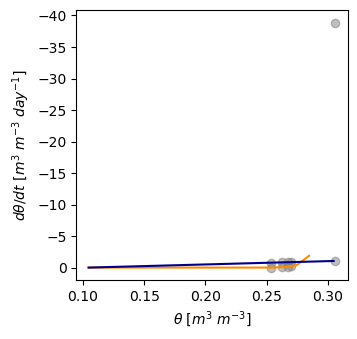

In [83]:
################################################
event_id = 28729
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

<ipython-input-75-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            4
EASE_row_index                                                      107
EASE_column_index                                                   193
event_start                                                  2018-02-22
event_end                                                    2018-02-27
time                                                        [0 1 3 4 5]
sm                    [0.2730568  0.21128891 0.22534607 0.18925148 0...
min_sm                                                         0.079824
max_sm                                                         0.497527
est_theta_fc                                                   0.296326
pet                                                            3.581087
tauexp_delta_theta                                              0.07474
tauexp_theta_w                                                 0.189251
tauexp_tau                                                     1

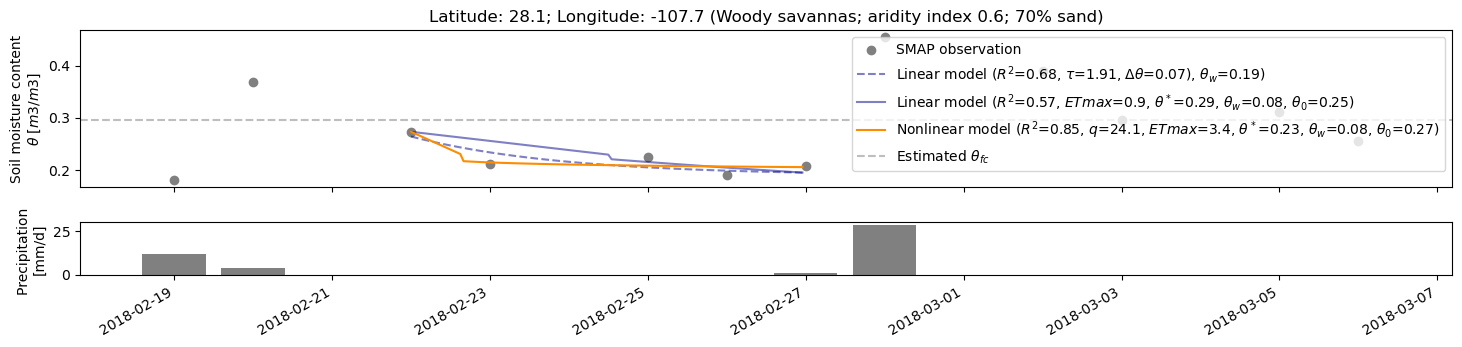

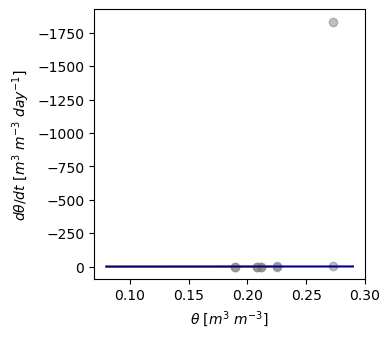

In [84]:
################################################
event_id = 64901
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

Restarted SMAP (Python 3.12.2)

In [1]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
)
import matplotlib.gridspec as gridspec

In [2]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2024-05-09"  # f"raraki_2024-04-26"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
z_mm = 50  # Soil thickness

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
}

In [3]:
# DATA IMPORT

# Data dir
user_name = getpass.getuser()
data_dir = rf"/home/{user_name}/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"
coord_info_file = "coord_info.csv"

# Read the output
output_dir = rf"/home/{user_name}/waves/projects/smap-drydown/output"
results_file = rf"all_results.csv"
_df = pd.read_csv(os.path.join(output_dir, dir_name, results_file))
print("Loaded results file")

# Read coordinate information
coord_info = pd.read_csv(os.path.join(data_dir, datarod_dir, coord_info_file))
df = _df.merge(coord_info, on=["EASE_row_index", "EASE_column_index"], how="left")
print("Loaded coordinate information")

# Ancillary data
df_anc = pd.read_csv(os.path.join(data_dir, datarod_dir, anc_file)).drop(
    ["spatial_ref", "latitude", "longitude"], axis=1
)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
print("Loaded ancillary information (sand fraction and land-cover)")

# Aridity indices
df_ai = pd.read_csv(os.path.join(data_dir, datarod_dir, ai_file)).drop(
    ["latitude", "longitude"], axis=1
)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
print("Loaded ancillary information (aridity index)")

IGBPclass = pd.read_csv(os.path.join(data_dir, anc_dir, IGBPclass_file))
IGBPclass.rename({"name": "landcover_name"}, inplace=True)

df = df.merge(df_anc, on=["EASE_row_index", "EASE_column_index"], how="left")
df = df.merge(df_ai, on=["EASE_row_index", "EASE_column_index"], how="left")
df = pd.merge(df, IGBPclass, left_on="IGBP_landcover", right_on="class", how="left")
print("Loaded ancillary information (land-cover)")

print(f"Total number of drydown event: {len(df)}")

Loaded results file
Loaded coordinate information
Loaded ancillary information (sand fraction and land-cover)
Loaded ancillary information (aridity index)
Loaded ancillary information (land-cover)
Total number of drydown event: 71828


In [4]:
fig_dir = os.path.join(output_dir, dir_name, "figs", "events")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Created dir: {fig_dir}")
else:
    print(f"Already exists: {fig_dir}")

Already exists: /home/raraki/waves/projects/smap-drydown/output/raraki_2024-05-09/figs/events


In [5]:
###################################
# Get some stats

# Difference between R2 values of two models
df = df.assign(diff_R2=df["q_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from q model
# df["q_ETmax"] = df["q_k"] * (df["max_sm"] - df["min_sm"]) * z_mm
# df["q_k_denormalized"] = df["q_k"] * (df["max_sm"] - df["min_sm"])


# def filter_by_data_availability(df):
#     # Define a helper function to convert string to list
#     def str_to_list(s):
#         return list(map(int, s.strip("[]").split()))

#     # Convert the 'time' column from string of lists to actual lists
#     df["time_list"] = df["time"].apply(str_to_list)

#     # Filter condition 1: Check if first three items are [0, 1, 2]
#     condition = df["time_list"].apply(lambda x: x[:3] == [0, 1, 2])

#     # condition = df['time_list'].apply(
#     #     lambda x: len(set(x[:4]).intersection({0, 1, 2, 3})) >= 3
#     # )

#     # Apply the first filter
#     filtered_df = df[condition]

#     return filtered_df


# print(len(df))
# df = filter_by_data_availability(df)
# print(len(df))


# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)


def calculate_n_days(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    n_days = len(sm)
    return n_days


# Applying the function to each row and creating a new column 'sm_range'
df["n_days"] = df.apply(calculate_n_days, axis=1)

df["event_length"] = (
    pd.to_datetime(df["event_end"]) - pd.to_datetime(df["event_start"])
).dt.days

In [6]:
############################################################
# Get timeseries of SM data
############################################################


def get_filename(varname, EASE_row_index, EASE_column_index):
    """Get the filename of the datarod"""
    filename = f"{varname}_{EASE_row_index:03d}_{EASE_column_index:03d}.csv"
    return filename


def set_time_index(df, index_name="time"):
    """Set the datetime index to the pandas dataframe"""
    df[index_name] = pd.to_datetime(df[index_name])
    return df.set_index("time")


def get_dataframe(varname, event):
    """Get the pandas dataframe for a datarod of interest

    Args:
        varname (string): name of the variable: "SPL3SMP", "PET", "SPL4SMGP"

    Returns:
        dataframe: Return dataframe with datetime index, cropped for the timeperiod for a variable
    """

    fn = get_filename(
        varname,
        EASE_row_index=event.EASE_row_index,
        EASE_column_index=event.EASE_column_index,
    )
    _df = pd.read_csv(os.path.join(data_dir, datarod_dir, varname, fn))

    # Set time index and crop
    df = set_time_index(_df, index_name="time")
    return df


def get_soil_moisture(varname="SPL3SMP", event=None):
    """Get a datarod of soil moisture data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Use retrieval flag to quality control the data
    condition_bad_data_am = (
        _df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 8.0)
    condition_bad_data_pm = (
        _df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 8.0)
    _df.loc[condition_bad_data_am, "Soil_Moisture_Retrieval_Data_AM_soil_moisture"] = (
        np.nan
    )
    _df.loc[
        condition_bad_data_pm, "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm"
    ] = np.nan

    # If there is two different versions of 2015-03-31 data --- remove this
    df = _df.loc[~_df.index.duplicated(keep="first")]

    # Resample to regular time interval
    df = df.resample("D").asfreq()

    # Merge the AM and PM soil moisture data into one daily timeseries of data
    df["soil_moisture_daily"] = df[
        [
            "Soil_Moisture_Retrieval_Data_AM_soil_moisture",
            "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm",
        ]
    ].mean(axis=1, skipna=True)

    return df["soil_moisture_daily"]


def get_precipitation(varname="SPL4SMGP", event=None):
    """Get a datarod of precipitation data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Drop unnccesary dimension and change variable name
    _df = _df.drop(columns=["x", "y"]).rename(
        {"precipitation_total_surface_flux": "precip"}, axis="columns"
    )

    # Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
    _df.precip = _df.precip * 86400

    # Resample to regular time interval
    return _df.resample("D").asfreq()

In [7]:
event = df.loc[event_id]

NameError: name 'event_id' is not defined

In [ ]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

: 

In [ ]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

: 

In [ ]:
################################################
event_id = 64901
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

: 

In [8]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [9]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([  652,   766,   768,   811,   903,  1607,  1770,  1799,  1802,  1867,
       ...
       63886, 64901, 65884, 66507, 66582, 66664, 68577, 69604, 70993, 71100],
      dtype='int64', length=186)
Try: Index([10949, 6562, 56550, 24891, 57182], dtype='int64')


<ipython-input-8-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            4
EASE_row_index                                                      107
EASE_column_index                                                   193
event_start                                                  2018-02-22
event_end                                                    2018-02-27
time                                                        [0 1 3 4 5]
sm                    [0.2730568  0.21128891 0.22534607 0.18925148 0...
min_sm                                                         0.079824
max_sm                                                         0.497527
est_theta_fc                                                   0.296326
pet                                                            3.581087
tauexp_delta_theta                                              0.07474
tauexp_theta_w                                                 0.189251
tauexp_tau                                                     1

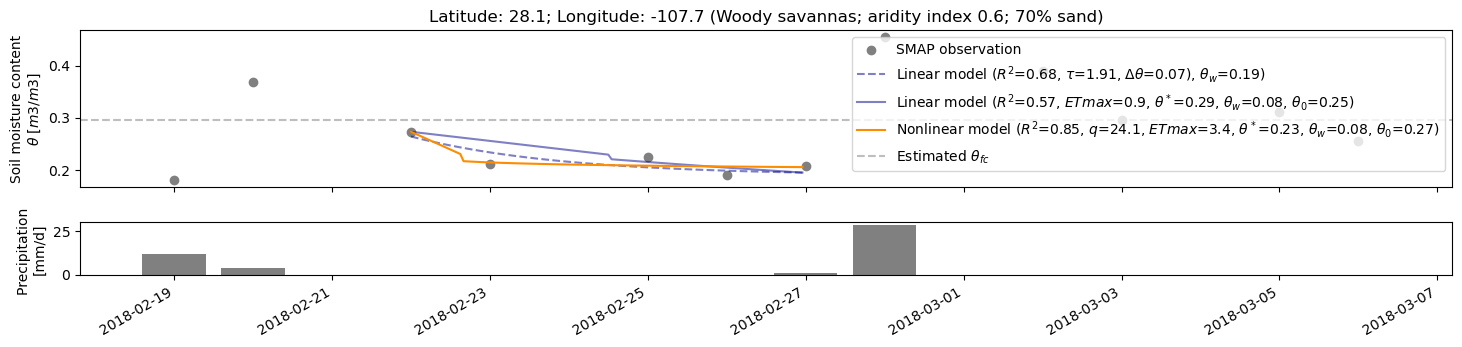

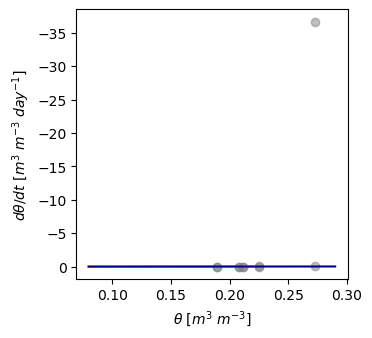

In [10]:
################################################
event_id = 64901
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

<ipython-input-8-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            5
EASE_row_index                                                       56
EASE_column_index                                                   216
event_start                                                  2017-08-18
event_end                                                    2017-08-24
time                                                    [0 1 2 3 4 5 6]
sm                    [0.28858459 0.26250848 0.25515094 0.25910565 0...
min_sm                                                         0.110897
max_sm                                                         0.447087
est_theta_fc                                                   0.291073
pet                                                            5.010237
tauexp_delta_theta                                             0.033369
tauexp_theta_w                                                 0.255151
tauexp_tau                                                     0

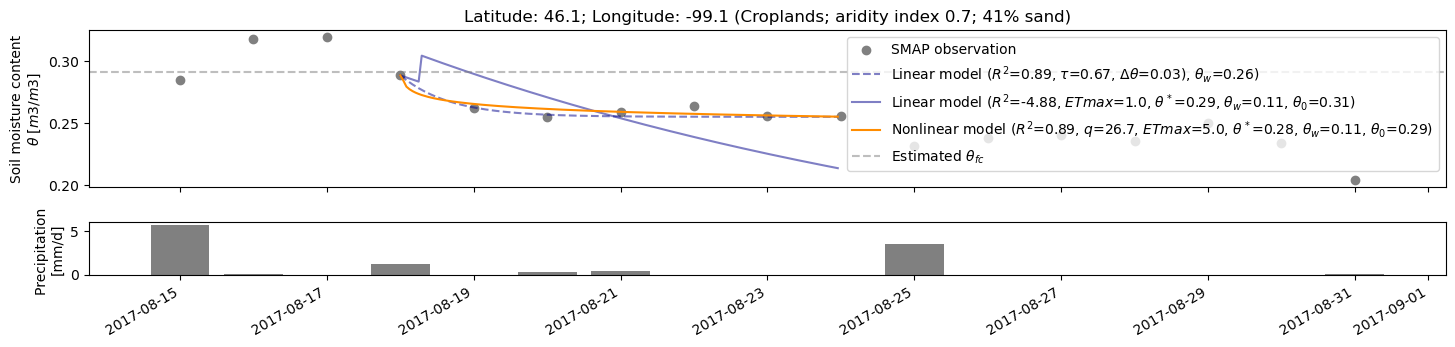

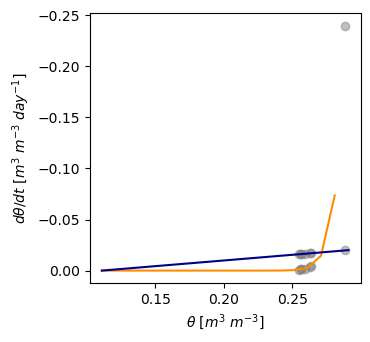

In [11]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

Restarted SMAP (Python 3.12.2)

In [1]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
)
import matplotlib.gridspec as gridspec

In [2]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2024-05-09"  # f"raraki_2024-04-26"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
z_mm = 50  # Soil thickness

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
}

In [3]:
# DATA IMPORT

# Data dir
user_name = getpass.getuser()
data_dir = rf"/home/{user_name}/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"
coord_info_file = "coord_info.csv"

# Read the output
output_dir = rf"/home/{user_name}/waves/projects/smap-drydown/output"
results_file = rf"all_results.csv"
_df = pd.read_csv(os.path.join(output_dir, dir_name, results_file))
print("Loaded results file")

# Read coordinate information
coord_info = pd.read_csv(os.path.join(data_dir, datarod_dir, coord_info_file))
df = _df.merge(coord_info, on=["EASE_row_index", "EASE_column_index"], how="left")
print("Loaded coordinate information")

# Ancillary data
df_anc = pd.read_csv(os.path.join(data_dir, datarod_dir, anc_file)).drop(
    ["spatial_ref", "latitude", "longitude"], axis=1
)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
print("Loaded ancillary information (sand fraction and land-cover)")

# Aridity indices
df_ai = pd.read_csv(os.path.join(data_dir, datarod_dir, ai_file)).drop(
    ["latitude", "longitude"], axis=1
)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
print("Loaded ancillary information (aridity index)")

IGBPclass = pd.read_csv(os.path.join(data_dir, anc_dir, IGBPclass_file))
IGBPclass.rename({"name": "landcover_name"}, inplace=True)

df = df.merge(df_anc, on=["EASE_row_index", "EASE_column_index"], how="left")
df = df.merge(df_ai, on=["EASE_row_index", "EASE_column_index"], how="left")
df = pd.merge(df, IGBPclass, left_on="IGBP_landcover", right_on="class", how="left")
print("Loaded ancillary information (land-cover)")

print(f"Total number of drydown event: {len(df)}")

Loaded results file
Loaded coordinate information
Loaded ancillary information (sand fraction and land-cover)
Loaded ancillary information (aridity index)
Loaded ancillary information (land-cover)
Total number of drydown event: 71828


In [4]:
fig_dir = os.path.join(output_dir, dir_name, "figs", "events")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Created dir: {fig_dir}")
else:
    print(f"Already exists: {fig_dir}")

Already exists: /home/raraki/waves/projects/smap-drydown/output/raraki_2024-05-09/figs/events


In [5]:
###################################
# Get some stats

# Difference between R2 values of two models
df = df.assign(diff_R2=df["q_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from q model
# df["q_ETmax"] = df["q_k"] * (df["max_sm"] - df["min_sm"]) * z_mm
# df["q_k_denormalized"] = df["q_k"] * (df["max_sm"] - df["min_sm"])


# def filter_by_data_availability(df):
#     # Define a helper function to convert string to list
#     def str_to_list(s):
#         return list(map(int, s.strip("[]").split()))

#     # Convert the 'time' column from string of lists to actual lists
#     df["time_list"] = df["time"].apply(str_to_list)

#     # Filter condition 1: Check if first three items are [0, 1, 2]
#     condition = df["time_list"].apply(lambda x: x[:3] == [0, 1, 2])

#     # condition = df['time_list'].apply(
#     #     lambda x: len(set(x[:4]).intersection({0, 1, 2, 3})) >= 3
#     # )

#     # Apply the first filter
#     filtered_df = df[condition]

#     return filtered_df


# print(len(df))
# df = filter_by_data_availability(df)
# print(len(df))


# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)


def calculate_n_days(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    n_days = len(sm)
    return n_days


# Applying the function to each row and creating a new column 'sm_range'
df["n_days"] = df.apply(calculate_n_days, axis=1)

df["event_length"] = (
    pd.to_datetime(df["event_end"]) - pd.to_datetime(df["event_start"])
).dt.days

In [6]:
############################################################
# Get timeseries of SM data
############################################################


def get_filename(varname, EASE_row_index, EASE_column_index):
    """Get the filename of the datarod"""
    filename = f"{varname}_{EASE_row_index:03d}_{EASE_column_index:03d}.csv"
    return filename


def set_time_index(df, index_name="time"):
    """Set the datetime index to the pandas dataframe"""
    df[index_name] = pd.to_datetime(df[index_name])
    return df.set_index("time")


def get_dataframe(varname, event):
    """Get the pandas dataframe for a datarod of interest

    Args:
        varname (string): name of the variable: "SPL3SMP", "PET", "SPL4SMGP"

    Returns:
        dataframe: Return dataframe with datetime index, cropped for the timeperiod for a variable
    """

    fn = get_filename(
        varname,
        EASE_row_index=event.EASE_row_index,
        EASE_column_index=event.EASE_column_index,
    )
    _df = pd.read_csv(os.path.join(data_dir, datarod_dir, varname, fn))

    # Set time index and crop
    df = set_time_index(_df, index_name="time")
    return df


def get_soil_moisture(varname="SPL3SMP", event=None):
    """Get a datarod of soil moisture data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Use retrieval flag to quality control the data
    condition_bad_data_am = (
        _df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 8.0)
    condition_bad_data_pm = (
        _df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 8.0)
    _df.loc[condition_bad_data_am, "Soil_Moisture_Retrieval_Data_AM_soil_moisture"] = (
        np.nan
    )
    _df.loc[
        condition_bad_data_pm, "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm"
    ] = np.nan

    # If there is two different versions of 2015-03-31 data --- remove this
    df = _df.loc[~_df.index.duplicated(keep="first")]

    # Resample to regular time interval
    df = df.resample("D").asfreq()

    # Merge the AM and PM soil moisture data into one daily timeseries of data
    df["soil_moisture_daily"] = df[
        [
            "Soil_Moisture_Retrieval_Data_AM_soil_moisture",
            "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm",
        ]
    ].mean(axis=1, skipna=True)

    return df["soil_moisture_daily"]


def get_precipitation(varname="SPL4SMGP", event=None):
    """Get a datarod of precipitation data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Drop unnccesary dimension and change variable name
    _df = _df.drop(columns=["x", "y"]).rename(
        {"precipitation_total_surface_flux": "precip"}, axis="columns"
    )

    # Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
    _df.precip = _df.precip * 86400

    # Resample to regular time interval
    return _df.resample("D").asfreq()

In [7]:
event = df.loc[event_id]

NameError: name 'event_id' is not defined

In [ ]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

: 

In [ ]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

: 

In [ ]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

: 

In [8]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [9]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([  652,   766,   768,   811,   903,  1607,  1770,  1799,  1802,  1867,
       ...
       63886, 64901, 65884, 66507, 66582, 66664, 68577, 69604, 70993, 71100],
      dtype='int64', length=186)
Try: Index([24891, 27471, 14948, 20485, 59611], dtype='int64')


<ipython-input-8-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            5
EASE_row_index                                                       56
EASE_column_index                                                   216
event_start                                                  2017-08-18
event_end                                                    2017-08-24
time                                                    [0 1 2 3 4 5 6]
sm                    [0.28858459 0.26250848 0.25515094 0.25910565 0...
min_sm                                                         0.110897
max_sm                                                         0.447087
est_theta_fc                                                   0.291073
pet                                                            5.010237
tauexp_delta_theta                                             0.033369
tauexp_theta_w                                                 0.255151
tauexp_tau                                                     0

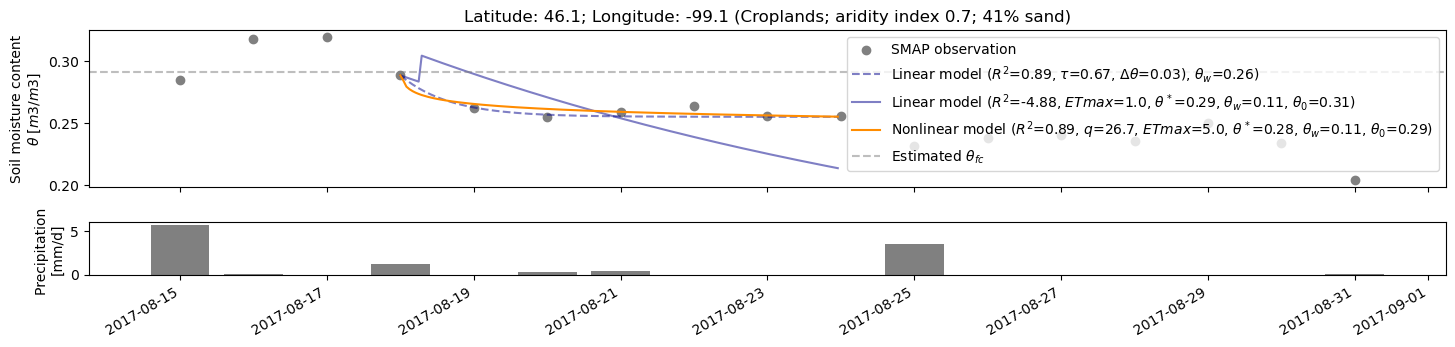

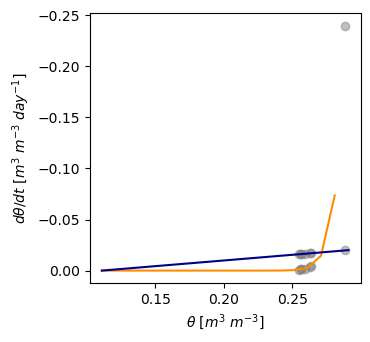

In [10]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

Restarted SMAP (Python 3.12.2)

In [1]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
)
import matplotlib.gridspec as gridspec

In [2]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2024-05-09"  # f"raraki_2024-04-26"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
z_mm = 50  # Soil thickness

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
}

In [3]:
# DATA IMPORT

# Data dir
user_name = getpass.getuser()
data_dir = rf"/home/{user_name}/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"
coord_info_file = "coord_info.csv"

# Read the output
output_dir = rf"/home/{user_name}/waves/projects/smap-drydown/output"
results_file = rf"all_results.csv"
_df = pd.read_csv(os.path.join(output_dir, dir_name, results_file))
print("Loaded results file")

# Read coordinate information
coord_info = pd.read_csv(os.path.join(data_dir, datarod_dir, coord_info_file))
df = _df.merge(coord_info, on=["EASE_row_index", "EASE_column_index"], how="left")
print("Loaded coordinate information")

# Ancillary data
df_anc = pd.read_csv(os.path.join(data_dir, datarod_dir, anc_file)).drop(
    ["spatial_ref", "latitude", "longitude"], axis=1
)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
print("Loaded ancillary information (sand fraction and land-cover)")

# Aridity indices
df_ai = pd.read_csv(os.path.join(data_dir, datarod_dir, ai_file)).drop(
    ["latitude", "longitude"], axis=1
)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
print("Loaded ancillary information (aridity index)")

IGBPclass = pd.read_csv(os.path.join(data_dir, anc_dir, IGBPclass_file))
IGBPclass.rename({"name": "landcover_name"}, inplace=True)

df = df.merge(df_anc, on=["EASE_row_index", "EASE_column_index"], how="left")
df = df.merge(df_ai, on=["EASE_row_index", "EASE_column_index"], how="left")
df = pd.merge(df, IGBPclass, left_on="IGBP_landcover", right_on="class", how="left")
print("Loaded ancillary information (land-cover)")

print(f"Total number of drydown event: {len(df)}")

Loaded results file
Loaded coordinate information
Loaded ancillary information (sand fraction and land-cover)
Loaded ancillary information (aridity index)
Loaded ancillary information (land-cover)
Total number of drydown event: 71828


In [4]:
fig_dir = os.path.join(output_dir, dir_name, "figs", "events")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Created dir: {fig_dir}")
else:
    print(f"Already exists: {fig_dir}")

Already exists: /home/raraki/waves/projects/smap-drydown/output/raraki_2024-05-09/figs/events


In [5]:
###################################
# Get some stats

# Difference between R2 values of two models
df = df.assign(diff_R2=df["q_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from q model
# df["q_ETmax"] = df["q_k"] * (df["max_sm"] - df["min_sm"]) * z_mm
# df["q_k_denormalized"] = df["q_k"] * (df["max_sm"] - df["min_sm"])


# def filter_by_data_availability(df):
#     # Define a helper function to convert string to list
#     def str_to_list(s):
#         return list(map(int, s.strip("[]").split()))

#     # Convert the 'time' column from string of lists to actual lists
#     df["time_list"] = df["time"].apply(str_to_list)

#     # Filter condition 1: Check if first three items are [0, 1, 2]
#     condition = df["time_list"].apply(lambda x: x[:3] == [0, 1, 2])

#     # condition = df['time_list'].apply(
#     #     lambda x: len(set(x[:4]).intersection({0, 1, 2, 3})) >= 3
#     # )

#     # Apply the first filter
#     filtered_df = df[condition]

#     return filtered_df


# print(len(df))
# df = filter_by_data_availability(df)
# print(len(df))


# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)


def calculate_n_days(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    n_days = len(sm)
    return n_days


# Applying the function to each row and creating a new column 'sm_range'
df["n_days"] = df.apply(calculate_n_days, axis=1)

df["event_length"] = (
    pd.to_datetime(df["event_end"]) - pd.to_datetime(df["event_start"])
).dt.days

In [6]:
############################################################
# Get timeseries of SM data
############################################################


def get_filename(varname, EASE_row_index, EASE_column_index):
    """Get the filename of the datarod"""
    filename = f"{varname}_{EASE_row_index:03d}_{EASE_column_index:03d}.csv"
    return filename


def set_time_index(df, index_name="time"):
    """Set the datetime index to the pandas dataframe"""
    df[index_name] = pd.to_datetime(df[index_name])
    return df.set_index("time")


def get_dataframe(varname, event):
    """Get the pandas dataframe for a datarod of interest

    Args:
        varname (string): name of the variable: "SPL3SMP", "PET", "SPL4SMGP"

    Returns:
        dataframe: Return dataframe with datetime index, cropped for the timeperiod for a variable
    """

    fn = get_filename(
        varname,
        EASE_row_index=event.EASE_row_index,
        EASE_column_index=event.EASE_column_index,
    )
    _df = pd.read_csv(os.path.join(data_dir, datarod_dir, varname, fn))

    # Set time index and crop
    df = set_time_index(_df, index_name="time")
    return df


def get_soil_moisture(varname="SPL3SMP", event=None):
    """Get a datarod of soil moisture data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Use retrieval flag to quality control the data
    condition_bad_data_am = (
        _df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 8.0)
    condition_bad_data_pm = (
        _df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 8.0)
    _df.loc[condition_bad_data_am, "Soil_Moisture_Retrieval_Data_AM_soil_moisture"] = (
        np.nan
    )
    _df.loc[
        condition_bad_data_pm, "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm"
    ] = np.nan

    # If there is two different versions of 2015-03-31 data --- remove this
    df = _df.loc[~_df.index.duplicated(keep="first")]

    # Resample to regular time interval
    df = df.resample("D").asfreq()

    # Merge the AM and PM soil moisture data into one daily timeseries of data
    df["soil_moisture_daily"] = df[
        [
            "Soil_Moisture_Retrieval_Data_AM_soil_moisture",
            "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm",
        ]
    ].mean(axis=1, skipna=True)

    return df["soil_moisture_daily"]


def get_precipitation(varname="SPL4SMGP", event=None):
    """Get a datarod of precipitation data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Drop unnccesary dimension and change variable name
    _df = _df.drop(columns=["x", "y"]).rename(
        {"precipitation_total_surface_flux": "precip"}, axis="columns"
    )

    # Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
    _df.precip = _df.precip * 86400

    # Resample to regular time interval
    return _df.resample("D").asfreq()

In [7]:
event = df.loc[event_id]

NameError: name 'event_id' is not defined

In [ ]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

: 

In [ ]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

: 

In [ ]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

: 

In [8]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [9]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([  652,   766,   768,   811,   903,  1607,  1770,  1799,  1802,  1867,
       ...
       63886, 64901, 65884, 66507, 66582, 66664, 68577, 69604, 70993, 71100],
      dtype='int64', length=186)
Try: Index([1881, 13083, 43068, 14862, 47045], dtype='int64')


<ipython-input-8-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            5
EASE_row_index                                                       56
EASE_column_index                                                   216
event_start                                                  2017-08-18
event_end                                                    2017-08-24
time                                                    [0 1 2 3 4 5 6]
sm                    [0.28858459 0.26250848 0.25515094 0.25910565 0...
min_sm                                                         0.110897
max_sm                                                         0.447087
est_theta_fc                                                   0.291073
pet                                                            5.010237
tauexp_delta_theta                                             0.033369
tauexp_theta_w                                                 0.255151
tauexp_tau                                                     0

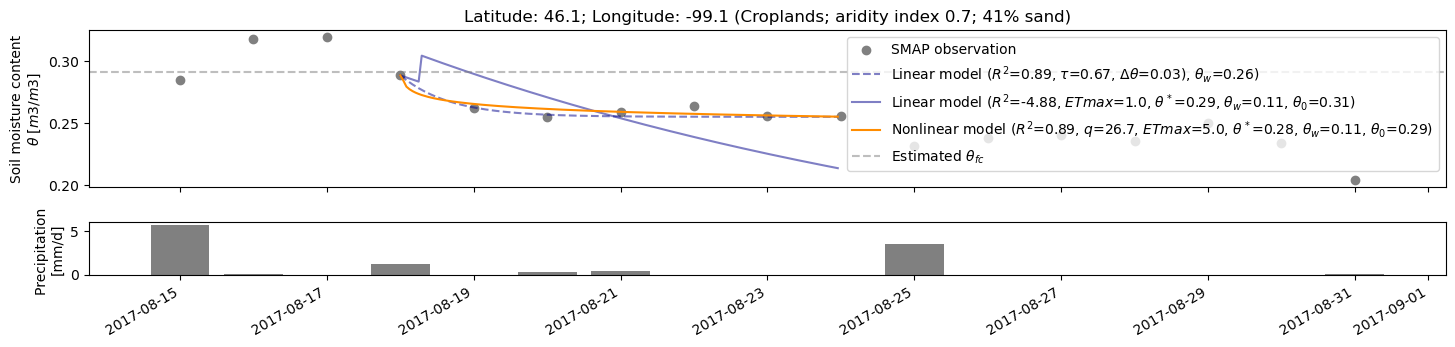

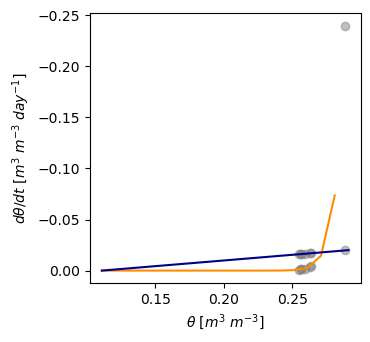

In [10]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

Restarted SMAP (Python 3.12.2)

In [1]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
)
import matplotlib.gridspec as gridspec

In [2]:
############ CHANGE HERE FOR CHECKING DIFFERENT RESULTS ###################
dir_name = f"raraki_2024-05-09"  # f"raraki_2024-04-26"
###########################################################################

################ CHANGE HERE FOR PLOT VISUAL CONFIG #########################

## Define model acceptabiltiy criteria
z_mm = 50  # Soil thickness

var_dict = {
    "theta": {
        "column_name": "sm",
        "symbol": r"$\theta$",
        "label": r"SMAP soil moisture",
        "unit": r"$[m^3/m^3]$",
        "lim": [0, 0.50],
    },
    "dtheta": {
        "column_name": "",
        "symbol": r"$-d\theta/dt$",
        "label": r"Change in soil moisture",
        "unit": r"$[m^3/m^3/day]$",
        "lim": [-0.10, 0],
    },
}

In [3]:
# DATA IMPORT

# Data dir
user_name = getpass.getuser()
data_dir = rf"/home/{user_name}/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"
coord_info_file = "coord_info.csv"

# Read the output
output_dir = rf"/home/{user_name}/waves/projects/smap-drydown/output"
results_file = rf"all_results.csv"
_df = pd.read_csv(os.path.join(output_dir, dir_name, results_file))
print("Loaded results file")

# Read coordinate information
coord_info = pd.read_csv(os.path.join(data_dir, datarod_dir, coord_info_file))
df = _df.merge(coord_info, on=["EASE_row_index", "EASE_column_index"], how="left")
print("Loaded coordinate information")

# Ancillary data
df_anc = pd.read_csv(os.path.join(data_dir, datarod_dir, anc_file)).drop(
    ["spatial_ref", "latitude", "longitude"], axis=1
)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
print("Loaded ancillary information (sand fraction and land-cover)")

# Aridity indices
df_ai = pd.read_csv(os.path.join(data_dir, datarod_dir, ai_file)).drop(
    ["latitude", "longitude"], axis=1
)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
print("Loaded ancillary information (aridity index)")

IGBPclass = pd.read_csv(os.path.join(data_dir, anc_dir, IGBPclass_file))
IGBPclass.rename({"name": "landcover_name"}, inplace=True)

df = df.merge(df_anc, on=["EASE_row_index", "EASE_column_index"], how="left")
df = df.merge(df_ai, on=["EASE_row_index", "EASE_column_index"], how="left")
df = pd.merge(df, IGBPclass, left_on="IGBP_landcover", right_on="class", how="left")
print("Loaded ancillary information (land-cover)")

print(f"Total number of drydown event: {len(df)}")

Loaded results file
Loaded coordinate information
Loaded ancillary information (sand fraction and land-cover)
Loaded ancillary information (aridity index)
Loaded ancillary information (land-cover)
Total number of drydown event: 71828


In [4]:
fig_dir = os.path.join(output_dir, dir_name, "figs", "events")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Created dir: {fig_dir}")
else:
    print(f"Already exists: {fig_dir}")

Already exists: /home/raraki/waves/projects/smap-drydown/output/raraki_2024-05-09/figs/events


In [5]:
###################################
# Get some stats

# Difference between R2 values of two models
df = df.assign(diff_R2=df["q_r_squared"] - df["exp_r_squared"])

# Denormalize k and calculate the estimated ETmax values from k parameter from q model
# df["q_ETmax"] = df["q_k"] * (df["max_sm"] - df["min_sm"]) * z_mm
# df["q_k_denormalized"] = df["q_k"] * (df["max_sm"] - df["min_sm"])


# def filter_by_data_availability(df):
#     # Define a helper function to convert string to list
#     def str_to_list(s):
#         return list(map(int, s.strip("[]").split()))

#     # Convert the 'time' column from string of lists to actual lists
#     df["time_list"] = df["time"].apply(str_to_list)

#     # Filter condition 1: Check if first three items are [0, 1, 2]
#     condition = df["time_list"].apply(lambda x: x[:3] == [0, 1, 2])

#     # condition = df['time_list'].apply(
#     #     lambda x: len(set(x[:4]).intersection({0, 1, 2, 3})) >= 3
#     # )

#     # Apply the first filter
#     filtered_df = df[condition]

#     return filtered_df


# print(len(df))
# df = filter_by_data_availability(df)
# print(len(df))


# Soil mositure range covered by the observation
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    sm_range = (
        (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm)
        if row.max_sm != row.min_sm
        else np.nan
    )
    return sm_range


# Applying the function to each row and creating a new column 'sm_range'
df["sm_range"] = df.apply(calculate_sm_range, axis=1)


def calculate_n_days(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace("\n", " np.nan")
    input_string = input_string.replace(" nan", " np.nan")
    input_string = input_string.strip("[]")

    # Converting to numpy array and handling np.nan
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )

    # Calculating sm_range
    n_days = len(sm)
    return n_days


# Applying the function to each row and creating a new column 'sm_range'
df["n_days"] = df.apply(calculate_n_days, axis=1)

df["event_length"] = (
    pd.to_datetime(df["event_end"]) - pd.to_datetime(df["event_start"])
).dt.days

In [6]:
############################################################
# Get timeseries of SM data
############################################################


def get_filename(varname, EASE_row_index, EASE_column_index):
    """Get the filename of the datarod"""
    filename = f"{varname}_{EASE_row_index:03d}_{EASE_column_index:03d}.csv"
    return filename


def set_time_index(df, index_name="time"):
    """Set the datetime index to the pandas dataframe"""
    df[index_name] = pd.to_datetime(df[index_name])
    return df.set_index("time")


def get_dataframe(varname, event):
    """Get the pandas dataframe for a datarod of interest

    Args:
        varname (string): name of the variable: "SPL3SMP", "PET", "SPL4SMGP"

    Returns:
        dataframe: Return dataframe with datetime index, cropped for the timeperiod for a variable
    """

    fn = get_filename(
        varname,
        EASE_row_index=event.EASE_row_index,
        EASE_column_index=event.EASE_column_index,
    )
    _df = pd.read_csv(os.path.join(data_dir, datarod_dir, varname, fn))

    # Set time index and crop
    df = set_time_index(_df, index_name="time")
    return df


def get_soil_moisture(varname="SPL3SMP", event=None):
    """Get a datarod of soil moisture data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Use retrieval flag to quality control the data
    condition_bad_data_am = (
        _df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 8.0)
    condition_bad_data_pm = (
        _df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 8.0)
    _df.loc[condition_bad_data_am, "Soil_Moisture_Retrieval_Data_AM_soil_moisture"] = (
        np.nan
    )
    _df.loc[
        condition_bad_data_pm, "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm"
    ] = np.nan

    # If there is two different versions of 2015-03-31 data --- remove this
    df = _df.loc[~_df.index.duplicated(keep="first")]

    # Resample to regular time interval
    df = df.resample("D").asfreq()

    # Merge the AM and PM soil moisture data into one daily timeseries of data
    df["soil_moisture_daily"] = df[
        [
            "Soil_Moisture_Retrieval_Data_AM_soil_moisture",
            "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm",
        ]
    ].mean(axis=1, skipna=True)

    return df["soil_moisture_daily"]


def get_precipitation(varname="SPL4SMGP", event=None):
    """Get a datarod of precipitation data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Drop unnccesary dimension and change variable name
    _df = _df.drop(columns=["x", "y"]).rename(
        {"precipitation_total_surface_flux": "precip"}, axis="columns"
    )

    # Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
    _df.precip = _df.precip * 86400

    # Resample to regular time interval
    return _df.resample("D").asfreq()

In [7]:
event = df.loc[event_id]

NameError: name 'event_id' is not defined

In [8]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [9]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([  652,   766,   768,   811,   903,  1607,  1770,  1799,  1802,  1867,
       ...
       63886, 64901, 65884, 66507, 66582, 66664, 68577, 69604, 70993, 71100],
      dtype='int64', length=186)
Try: Index([10949, 14888, 57215, 39222, 30275], dtype='int64')


<ipython-input-8-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            5
EASE_row_index                                                       56
EASE_column_index                                                   216
event_start                                                  2017-08-18
event_end                                                    2017-08-24
time                                                    [0 1 2 3 4 5 6]
sm                    [0.28858459 0.26250848 0.25515094 0.25910565 0...
min_sm                                                         0.110897
max_sm                                                         0.447087
est_theta_fc                                                   0.291073
pet                                                            5.010237
tauexp_delta_theta                                             0.033369
tauexp_theta_w                                                 0.255151
tauexp_tau                                                     0

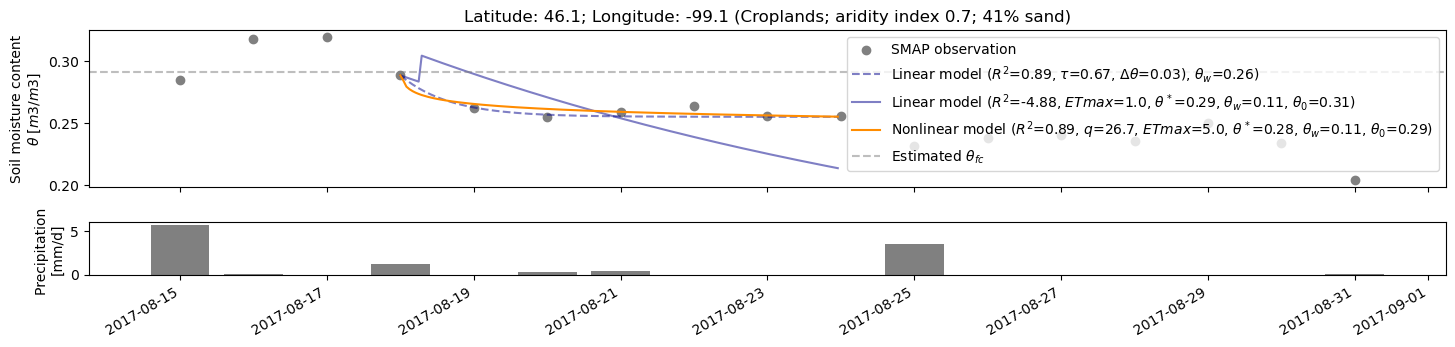

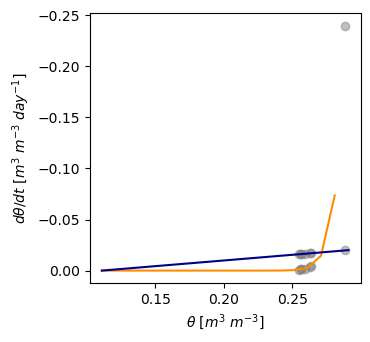

In [10]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [11]:
############################################################
# Get timeseries of SM data
############################################################


def get_filename(varname, EASE_row_index, EASE_column_index):
    """Get the filename of the datarod"""
    filename = f"{varname}_{EASE_row_index:03d}_{EASE_column_index:03d}.csv"
    return filename


def set_time_index(df, index_name="time"):
    """Set the datetime index to the pandas dataframe"""
    df[index_name] = pd.to_datetime(df[index_name])
    return df.set_index("time")


def get_dataframe(varname, event):
    """Get the pandas dataframe for a datarod of interest

    Args:
        varname (string): name of the variable: "SPL3SMP", "PET", "SPL4SMGP"

    Returns:
        dataframe: Return dataframe with datetime index, cropped for the timeperiod for a variable
    """

    fn = get_filename(
        varname,
        EASE_row_index=event.EASE_row_index,
        EASE_column_index=event.EASE_column_index,
    )
    _df = pd.read_csv(os.path.join(data_dir, datarod_dir, varname, fn))

    # Set time index and crop
    df = set_time_index(_df, index_name="time")
    return df


def get_soil_moisture(varname="SPL3SMP", event=None):
    """Get a datarod of soil moisture data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Use retrieval flag to quality control the data
    condition_bad_data_am = (
        _df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] != 8.0)
    condition_bad_data_pm = (
        _df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 0.0
    ) & (_df["Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm"] != 8.0)
    _df.loc[condition_bad_data_am, "Soil_Moisture_Retrieval_Data_AM_soil_moisture"] = (
        np.nan
    )
    _df.loc[
        condition_bad_data_pm, "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm"
    ] = np.nan

    # If there is two different versions of 2015-03-31 data --- remove this
    df = _df.loc[~_df.index.duplicated(keep="first")]

    # Resample to regular time interval
    df = df.resample("D").asfreq()

    # Merge the AM and PM soil moisture data into one daily timeseries of data
    df["soil_moisture_daily"] = df[
        [
            "Soil_Moisture_Retrieval_Data_AM_soil_moisture",
            "Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm",
        ]
    ].mean(axis=1, skipna=True)

    return df["soil_moisture_daily"]


def get_precipitation(varname="SPL4SMGP", event=None):
    """Get a datarod of precipitation data for a pixel"""

    # Get variable dataframe
    _df = get_dataframe(varname=varname, event=event)

    # Drop unnccesary dimension and change variable name
    _df = _df.drop(columns=["x", "y"]).rename(
        {"precipitation_total_surface_flux": "precip"}, axis="columns"
    )

    # Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day
    _df.precip = _df.precip * 86400

    # Resample to regular time interval
    return _df.resample("D").asfreq()

In [12]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [13]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([  652,   766,   768,   811,   903,  1607,  1770,  1799,  1802,  1867,
       ...
       63886, 64901, 65884, 66507, 66582, 66664, 68577, 69604, 70993, 71100],
      dtype='int64', length=186)
Try: Index([55095, 14567, 20924, 13232, 27471], dtype='int64')


<ipython-input-12-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            5
EASE_row_index                                                       56
EASE_column_index                                                   216
event_start                                                  2017-08-18
event_end                                                    2017-08-24
time                                                    [0 1 2 3 4 5 6]
sm                    [0.28858459 0.26250848 0.25515094 0.25910565 0...
min_sm                                                         0.110897
max_sm                                                         0.447087
est_theta_fc                                                   0.291073
pet                                                            5.010237
tauexp_delta_theta                                             0.033369
tauexp_theta_w                                                 0.255151
tauexp_tau                                                     0

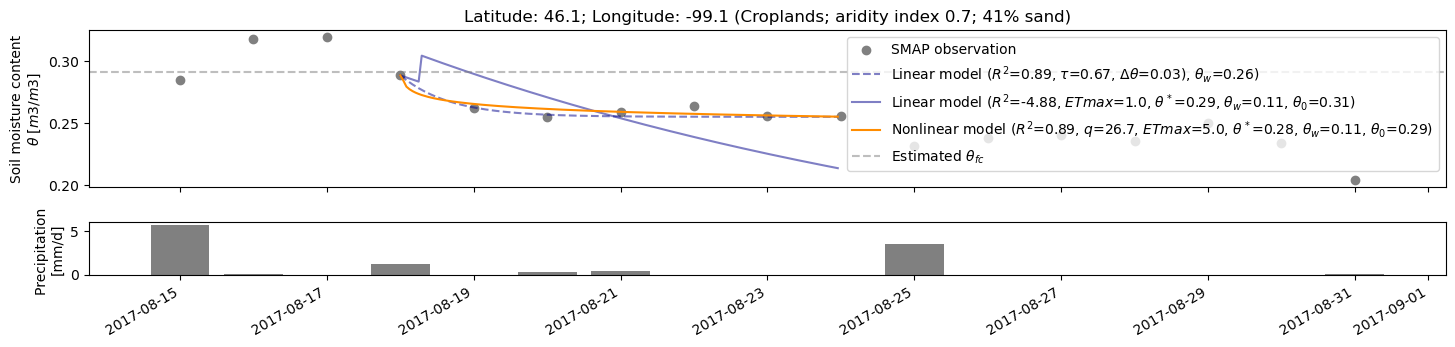

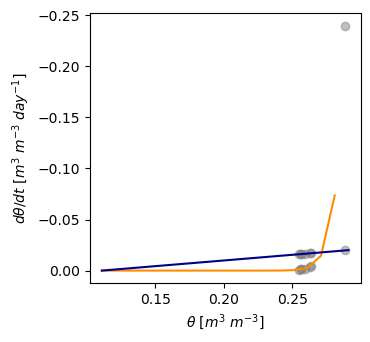

In [14]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [15]:
event

NameError: name 'event' is not defined

In [16]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
)
import matplotlib.gridspec as gridspec

In [17]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [18]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([  652,   766,   768,   811,   903,  1607,  1770,  1799,  1802,  1867,
       ...
       63886, 64901, 65884, 66507, 66582, 66664, 68577, 69604, 70993, 71100],
      dtype='int64', length=186)
Try: Index([34671, 16470, 15295, 14919, 55105], dtype='int64')


<ipython-input-17-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            5
EASE_row_index                                                       56
EASE_column_index                                                   216
event_start                                                  2017-08-18
event_end                                                    2017-08-24
time                                                    [0 1 2 3 4 5 6]
sm                    [0.28858459 0.26250848 0.25515094 0.25910565 0...
min_sm                                                         0.110897
max_sm                                                         0.447087
est_theta_fc                                                   0.291073
pet                                                            5.010237
tauexp_delta_theta                                             0.033369
tauexp_theta_w                                                 0.255151
tauexp_tau                                                     0

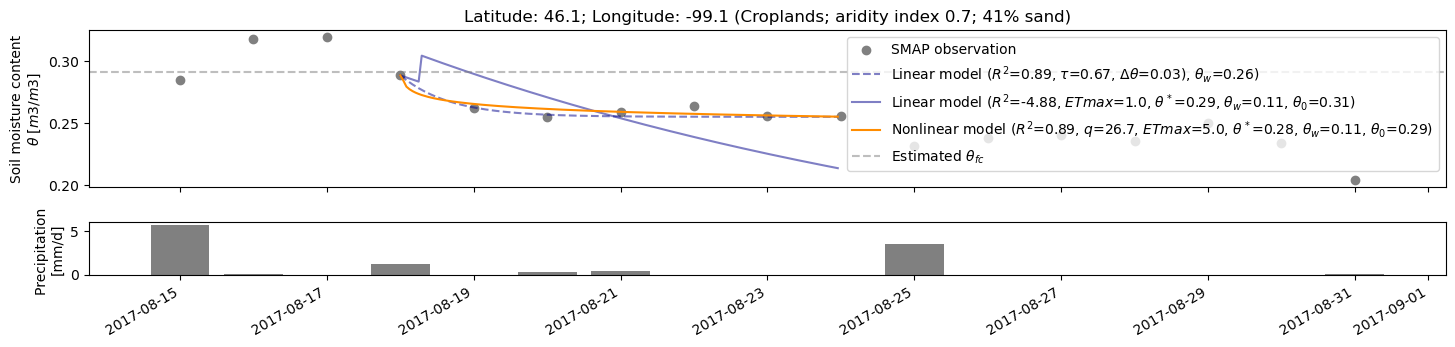

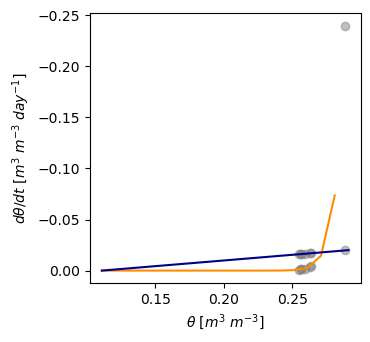

In [19]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [20]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
)
import matplotlib.gridspec as gridspec

In [21]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [22]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([  652,   766,   768,   811,   903,  1607,  1770,  1799,  1802,  1867,
       ...
       63886, 64901, 65884, 66507, 66582, 66664, 68577, 69604, 70993, 71100],
      dtype='int64', length=186)
Try: Index([37043, 55952, 19045, 17395, 42862], dtype='int64')


<ipython-input-21-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            5
EASE_row_index                                                       56
EASE_column_index                                                   216
event_start                                                  2017-08-18
event_end                                                    2017-08-24
time                                                    [0 1 2 3 4 5 6]
sm                    [0.28858459 0.26250848 0.25515094 0.25910565 0...
min_sm                                                         0.110897
max_sm                                                         0.447087
est_theta_fc                                                   0.291073
pet                                                            5.010237
tauexp_delta_theta                                             0.033369
tauexp_theta_w                                                 0.255151
tauexp_tau                                                     0

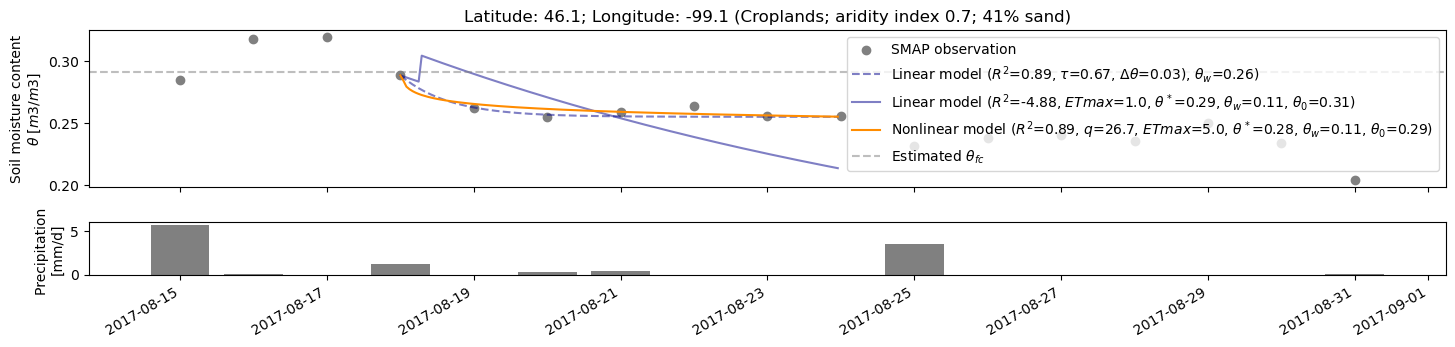

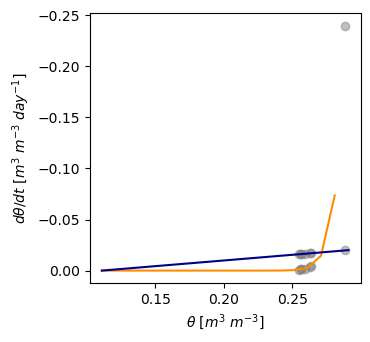

In [23]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [24]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
)
import matplotlib.gridspec as gridspec

In [25]:
def plot_drydown(df, event_id, ax=None, save=False):

    # Assuming 'df' is your DataFrame and 'event_id' is defined
    event = df.loc[event_id]

    ####################################################
    # Get the event data
    ####################################################
    # Convert the modified string to a NumPy array
    # Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
    input_string = (
        event.sm.replace("\n", " np.nan").replace(" nan", " np.nan").strip("[]")
    )
    sm = np.array(
        [
            float(value) if value != "np.nan" else np.nan
            for value in input_string.split()
        ]
    )
    values = event.time.strip("[]").split()
    # Calculating n_days
    n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days

    # Define variables and parameters
    t = np.arange(0, n_days, 1 / 24)

    y_q = drydown_piecewise(
        t=t,
        model=q_model(
            t,
            event.q_q,
            event.q_ETmax,
            event.q_theta_0,
            event.q_theta_star,
            event.q_theta_w,
            z=50.0,
        ),
        ETmax=event.q_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )
    y_exp = drydown_piecewise(
        t=t,
        model=exp_model(
            t,
            event.exp_ETmax,
            event.exp_theta_0,
            event.exp_theta_star,
            event.exp_theta_w,
            z=50.0,
        ),
        ETmax=event.exp_ETmax,
        theta_0=event.q_theta_0,
        theta_star=event.q_theta_star,
        z=50.0,
    )

    y_tauexp = tau_exp_model(
        t, event.tauexp_delta_theta, event.tauexp_theta_w, event.tauexp_tau
    )

    # Get soil moisture and precipitation timeseries
    df_ts = get_soil_moisture(event=event)
    df_p = get_precipitation(event=event)

    # Plotting settings
    q_label = rf"Nonlinear model ($R^2$={event.q_r_squared:.2f}, $q$={event.q_q:.1f}, $ETmax$={event.q_ETmax:.1f}, $\theta^*$={event.q_theta_star:.2f}, $\theta_w$={event.q_theta_w:.2f}, $\theta_0$={event.q_theta_0:.2f})"
    exp_label = rf"Linear model ($R^2$={event.exp_r_squared:.2f}, $ETmax$={event.exp_ETmax:.1f}, $\theta^*$={event.exp_theta_star:.2f}, $\theta_w$={event.exp_theta_w:.2f}, $\theta_0$={event.exp_theta_0:.2f})"
    tauexp_label = rf"Linear model ($R^2$={event.tauexp_r_squared:.2f}, $\tau$={event.tauexp_tau:.2f}, $\Delta \theta$={event.tauexp_delta_theta:.2f}), $\theta_w$={event.tauexp_theta_w:.2f})"

    start_date = pd.to_datetime(event.event_start) - pd.Timedelta(3, "D")
    end_date = pd.to_datetime(event.event_end) + pd.Timedelta(7, "D")
    date_range = pd.date_range(
        start=pd.to_datetime(event.event_start),
        end=pd.to_datetime(event.event_end),
        freq="H",
    )

    ####################################################
    # Drydown plot
    ####################################################

    fig = plt.figure(figsize=(15, 3.5))

    # Set up a GridSpec layout
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    # Create the subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)

    # Plot observed & fitted soil moisture
    ax1.scatter(
        df_ts[start_date:end_date].index,
        df_ts[start_date:end_date].values,
        color="grey",
        label="SMAP observation",
    )
    ax1.plot(
        date_range[:-1],
        y_tauexp,
        label=tauexp_label,
        color="darkblue",
        alpha=0.5,
        linestyle="--",
    )
    ax1.plot(date_range[:-1], y_exp, label=exp_label, color="darkblue", alpha=0.5)
    ax1.plot(date_range[:-1], y_q, label=q_label, color="darkorange")
    ax1.axhline(
        y=event.est_theta_fc,
        color="tab:grey",
        linestyle="--",
        alpha=0.5,
        label=r"Estimated $\theta_{fc}$",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Soil moisture content" + "\n" + rf"$\theta$ $[m3/m3]$")
    ax1.legend(loc="upper right")
    ax1.set_title(
        f"Latitude: {event.latitude:.1f}; Longitude: {event.longitude:.1f} ({event['name']}; aridity index {event.AI:.1f}; {event.sand_fraction*100:.0f}% sand)"
    )

    # Plot preciptation
    ax2.bar(
        df_p[start_date:end_date].index,
        df_p[start_date:end_date].values.flatten(),
        color="grey",
    )
    ax2.set_ylabel("Precipitation \n[mm/d]")

    # Formatting
    # Optional: Hide x-ticks for ax1 if they're redundant
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Adjust the subplots to prevent overlap
    plt.subplots_adjust(hspace=0.1)  # Adjust the space between plots if necessary

    fig.tight_layout()
    fig.autofmt_xdate()

    if save:
        fig.savefig(
            os.path.join(fig_dir, f"event_{event_id}.png"),
            dpi=1200,
            bbox_inches="tight",
        )

    # ####################################################
    # # Loss function
    # ####################################################

    fig2, ax3 = plt.subplots(figsize=(3.5, 3.5))

    nonlinear_theta_plot = np.arange(event.q_theta_w, event.q_theta_star, 0.01)
    linear_theta_plot = np.arange(event.exp_theta_w, event.exp_theta_star, 0.01)
    theta_obs = df_ts[
        pd.to_datetime(event.event_start) : pd.to_datetime(event.event_end)
    ].values

    # Plot observed & fitted soil moisture
    ax3.plot(
        nonlinear_theta_plot,
        loss_model(
            nonlinear_theta_plot,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="darkorange",
    )

    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            event.q_q,
            event.q_ETmax,
            theta_wp=event.q_theta_w,
            theta_star=event.q_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    # Plot observed & fitted soil moisture
    ax3.plot(
        linear_theta_plot,
        loss_model(
            linear_theta_plot,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="darkblue",
    )
    
    # Plot observed & fitted soil moisture
    ax3.scatter(
        theta_obs,
        loss_model(
            theta_obs,
            1,
            event.exp_ETmax,
            theta_wp=event.exp_theta_w,
            theta_star=event.exp_theta_star,
        ),
        color="grey",
        alpha=0.5,
    )

    ax3.set_xlabel(r"$\theta$ [$m^3$ $m^{-3}$]")
    ax3.set_ylabel(r"$d\theta/dt$ [$m^3$ $m^{-3}$ $day^{-1}$]")
    ax3.invert_yaxis()

In [26]:
# Select the events to plot here
###################################################
# Defining thresholds
q_thresh = 0
success_modelfit_thresh = 0.7
sm_range_thresh = 0.1
###################################################

# CONUS
lat_min, lat_max = 24.396308, 49.384358
lon_min, lon_max = -125.000000, -66.934570

df_filt = df[
    (df["q_r_squared"] > success_modelfit_thresh)
    & (df["q_q"] >15)
    # & (df["longitude"] >= lon_min)
    # & (df["longitude"] <= lon_max)
]

print(df_filt.index)
print(f"Try: {df_filt.sample(n=5).index}")

Index([  652,   766,   768,   811,   903,  1607,  1770,  1799,  1802,  1867,
       ...
       63886, 64901, 65884, 66507, 66582, 66664, 68577, 69604, 70993, 71100],
      dtype='int64', length=186)
Try: Index([7384, 50640, 6258, 20739, 11010], dtype='int64')


<ipython-input-25-11659c800728>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(


Unnamed: 0                                                            5
EASE_row_index                                                       56
EASE_column_index                                                   216
event_start                                                  2017-08-18
event_end                                                    2017-08-24
time                                                    [0 1 2 3 4 5 6]
sm                    [0.28858459 0.26250848 0.25515094 0.25910565 0...
min_sm                                                         0.110897
max_sm                                                         0.447087
est_theta_fc                                                   0.291073
pet                                                            5.010237
tauexp_delta_theta                                             0.033369
tauexp_theta_w                                                 0.255151
tauexp_tau                                                     0

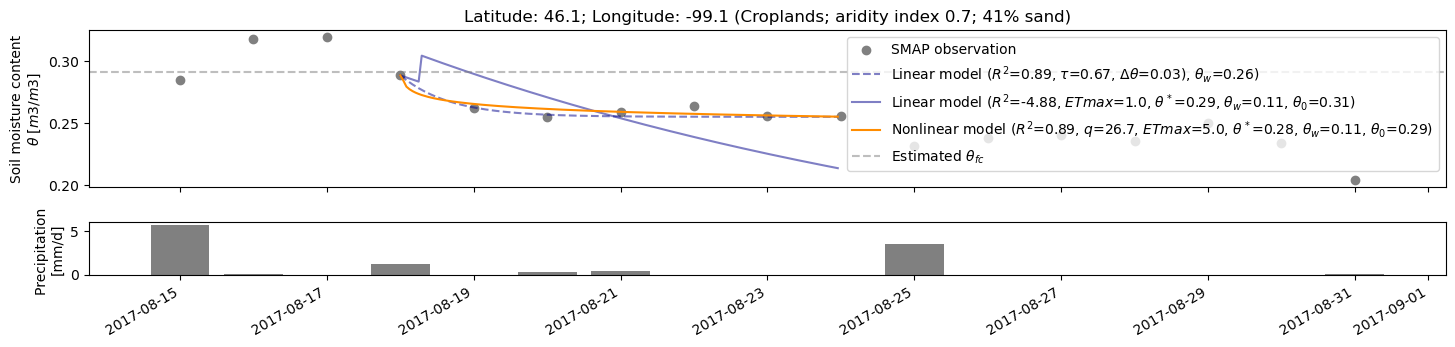

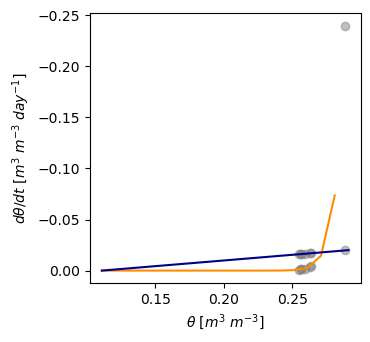

In [27]:
################################################
event_id = 7268
################################################
plot_drydown(df=df_filt, event_id=event_id)
print(df_filt.loc[event_id])
print(f"Next to try: {df_filt.sample(n=1).index}")

In [28]:
import os
import getpass
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions_v2 import (
    drydown_piecewise,
    q_model,
    exp_model,
    tau_exp_model,
    loss_model,
    q_model_piecewise,
    exp_model_piecewise,
)
import matplotlib.gridspec as gridspec

ImportError: cannot import name 'q_model_piecewise' from 'functions_v2' (/home/raraki/smap-drydown/notebooks/functions_v2.py)